# "The 'Alternative für Deutschland' and their usage of parliamentary speeches on Social Media"

## Information about the research project

In this project, which is the Masters Thesis of Moritz Stockmar, the usage of parliamentary speeches by the 'Alternative für Deutschland' (AfD) on Social Media is analyzed. The main objective is to learn which speeches (and parts thereof) are used by the AfD on TikTok and YouTube Shorts, what differentiates them form the population of all of AfD's parliamentary speeches.

To achieve this goal the following steps are taken:

1. Collecting the data: The speeches of the AfD are collected from the plenary protocolls which can be found on the official website of the Bundestag. The TikTok and YouTube Shorts videos are collected from official social media accounts of the AfD.

2. Preprocessing the data: A corpus of AfD speeches during the 20. legislative period of the Bundestag is built. The short videos are transcribed and matched to the corpus entries.

3. Analyzing the data: After alligning the uploaded speeches with the official parliamentary protocols, the speeches are analyzed using a variety of methods, such as topic modeling, sentiment analysis, syntactical analysis and more.

4. Visualising the data: The results are visualized to be presented in the Masters Thesis.

The steps above are also reflected in the structure of this md-document. Refer to the respective sections for more detailled information.
The data was (will be) collected by the author and is available on request. The goal is, that this markdown will be self contained and can be used to reproduce the results of the thesis.


## 0. Setting global options and loading the required libraries
The following sections load the required libraries and sets some global variables. This sections must be run before any other section

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import spacy
import bundestag_api
import os
import re
import torch
import whisper

import subprocess
import ast
import unicodedata

from spacy import displacy
from time import strftime, localtime

# Dowmload the required models

# Download and load the spaCy model
#!python -m spacy download de_core_news_md
nlp = spacy.load("de_core_news_md")
# @TODO: Trying it with a bigger model


# Whisper: The Turbo Model is used. It is 1.5 GB big in storage and uses roughly 6 GB of RAM. 
# https://huggingface.co/openai/whisper-large-v3-turbo
model = whisper.load_model("turbo")
# Hugging Face Models


"""
@TODO: The following code builds the recquired file structure for the project.
"""


'\n@TODO: The following code builds the recquired file structure for the project.\n'

In [ ]:
# Setting global variables
BUNDESTAG_API = "I9FKdCn.hbfefNWCY336dL6x62vfwNKpoN2RZ1gp21"
period_start = '2021-10-01'
period_end = '2025-03-24'

path_yt_faction = "data/raw_data/videos/YouTube/AfD-Fraktion Bundestag (Parliamentary Faction)/"
path_yt_party = "data/raw_data/videos/YouTube/AfD-TV (Party)/"
path_tt = "data/raw_data/videos/TikTok/"
path_insta_faction = "data/raw_data/videos/Instagram/InstaFaction/"
path_insta_party = "data/raw_data/videos/Instagram/InstaParty/"
paths_to_folders = [path_yt_faction, path_yt_party, path_tt, path_insta_faction, path_insta_party]

parties = ["CDU/CSU", "SPD", "AfD", "FDP", "BÜNDNIS 90/DIE GRÜNEN", "Die Linke", "BSW" "fraktionslos"]
länder = ["Baden-Württemberg", "Bayern", "Berlin", "Brandenburg", "Bremen", "Hamburg", "Hessen", "Mecklenburg-Vorpommern", "Niedersachsen", "Nordrhein-Westfalen", "Rheinland-Pfalz", "Saarland", "Sachsen", "Sachsen-Anhalt", "Schleswig-Holstein", "Thüringen"]


## 1. Collecting the Data
The plenary protocolls are collected using the [official API](https://dip.bundestag.de/%C3%BCber-dip/hilfe/api) of the German Bundestag. The [python-wrapper](https://github.com/jschibberges/Bundestag-API) by jschibberges is used to do it. The short videos were downloaded via the tool [youtube-dlp](https://github.com/yt-dlp/yt-dlp). This won't be shown here but the video database can be accessed on request.

### 1.1 Downloading the speeches

In [ ]:
""" 
Collecting the protocols from the Bundestag API from the first session of the 20th legislative period 
to the date of the election of the 21st legislative period. 

This codeblock takes some time to run as it collects the data from the Bundestag API. There are 214 protocols to download. 
Only do this once, as the data is saved to a CSV file for long term storage and the dataframe is pickled for shorter term storage.

@TODO: Add the sessions after the election of the 21st legislative period to the data collection
"""
bta = bundestag_api.btaConnection(apikey = BUNDESTAG_API)
protocols = bta.search_plenaryprotocol(date_start = period_start, date_end = period_end, institution = 'BT', num = 400, fulltext = True)
protocols_df  = pd.DataFrame(protocols)

# Save the dataframe
protocols_df.to_csv("data/raw_data/protocols.csv")
protocols_df.to_pickle("data/raw_data/protocols.pkl")

### 1.2 Downloading the MdB Information

In [ ]:
# Download persons from the Bundestag API. It is not completly clear how search_person works, therefore we will download all persons and filter them later.
bta = bundestag_api.btaConnection(apikey = BUNDESTAG_API)
persons = bta.search_person(updated_since = period_start + "T00:00:00", num = 3000)
persons_df = pd.DataFrame(persons)

# Filter the persons_df for AfD speakers, these can only be MdBs as the AfD does not have any ministers or MdBRs (Memebers of the Bundesrat)
# There are a few to many persons which can be explained by people leaving the faction (and now being crossbencher) or leaving parliament during the legislative period
filtered_afd_mdbs_df = persons_df[(persons_df['person_roles'].str.contains('AfD', na = False))| 
                                (persons_df['titel'].str.contains('AfD', na = False))]

# Filter the persons_df for non AfD speakers, these can be MdBs, Ministers and MdBRs 
# There is no need to filter for party other than not being in the AfD
filtered_non_afd_speekers_df = persons_df[~((persons_df['person_roles'].str.contains('AfD', na = False))| 
                                (persons_df['titel'].str.contains('AfD', na = False)))]

# Filters everyone out did not speak in the 20th legislative period
filtered_non_afd_speekers_df = filtered_non_afd_speekers_df.loc[
    # Simple lookup for the wahlperiode == 20 (This applies to everyone speaking for the first time in the 20th legislative period)
    (filtered_non_afd_speekers_df['wahlperiode'] == 20) |
    # Complicated lookup for everyone else (This applies to everyone who spoke before the 20th legislative period and in the 20th) 
    (filtered_non_afd_speekers_df['person_roles'].apply(
        lambda roles: isinstance(roles, list) and
        any(20 in role.get('wahlperiode_nummer', []) for role in roles if isinstance(role, dict))
    ))
]

# Save the dataframe
filtered_afd_mdbs_df.to_csv("data/raw_data/afd_mdbs.csv")
filtered_afd_mdbs_df.to_pickle("data/raw_data/afd_mdbs.pkl")

filtered_non_afd_speekers_df.to_csv("data/raw_data/non_afd_speakers.csv")
filtered_non_afd_speekers_df.to_pickle("data/raw_data/non_afd_speakers.pkl")

## 2. Preprocessing the data

In the following the preprocessing of the textual and the audio-visual data is performed. 

1. The textual data (the protocols) is processed into a annotated Corpus consisting of all speeches by AfD MdBs (members of the Bundestag). Therefor firstly all speeches of AfD MdBs have to be extracted (in plain text) from the protocols. The next step is the linguistical preprocessing performed by spaCy to make the data usable for the upcoming syntactical and semantical examinations.

2. The audio-visual data (the uploaded short videos) have to be transcribed.

3. The transcriptions are matched with their corresponding speeches from the frist step. 

### 2.1 Preprocessing the Text

#### 2.1.1 Extracting the AfD Speeches from the protocols

The following codeblock extracts the AfD Speeches from the protocols and stores them in a single dataframe

Attention: This block takes roughly 30s to complete on a M2 Mac.

In [ ]:
"""
The following code block reads the protocols from the CSV file / pickeled file and loads them into a pandas dataframe for further processing
if there is no dataframe already created.
"""
if os.path.exists("data/raw_data/protocols.pkl"):
    protocols_df = pd.read_pickle("data/raw_data/protocols.pkl")
elif os.path.exists("data/raw_data/protocols.csv"):
    protocols_df = pd.read_csv("data/raw_data/protocols.csv")
else:
    print("No data found. Please run the data collection code block first.")

"""The afd_mdbs_searchstrings are the strings signaling the start of every AfD Speech in the protocols by being of the form
'[o: Titels] [first name] [o: infix] [last name], (AfD):' -> things in brackets are individual, things with o: are optional
This searchstring can be used as is to find the start of the speech in the protocol """
afd_mdbs_searchstrings = filtered_afd_mdbs_df.apply(lambda row: row['titel'].replace(', MdB', '').replace('Dr. ', '').replace(', AfD', ' (AfD)') + ":", axis = 1).to_list()

"""The non_afd_searchstring is part of the string signaling the start of every non AfD speech in the protocols by being of the form
'[o: Titels] [first name] [o: infix] [last name]', The party or affiliation to the federal government or bundesrat is not included, because that would lead to many edge cases
This searchsting can NOT be used as is to find the start of the speech in the protocol """
non_afd_searchstings = filtered_non_afd_speekers_df.apply(lambda row: row['titel'].split(',')[0], axis = 1).to_list()


"""
Helper method to check if a line is the start of an AfD speech. This is done by checking if the line contains any of the searchstrings
and if the line does not contain the word "Frage" which indicates that the line is a purely written question and not a speech. 
These are found at the end of protocols if the time was to short to answer each question for the government orally.
"""
def is_start_of_AfDSpeech(line, searchstrings) -> bool:
    return any(searchstring in line for searchstring in searchstrings) and not "Frage" in line

"""
Second Helper method to check if a line is the start of an AfD speech which handels the case where the speaker announcement in the protocol
is split into two lines. It is only checked for "(AfD):" and the last name of the speaker. 

There are two known special cases: In the first case the line is split after the first name and the second case is that the line is split after the last name.
"""
def is_start_of_AfDSpeech_split_name(line, next_line, afd_mdbs_searchstrings) -> bool:
    if "(AfD):" in line and not "Frage" in line and any(nachname in line for nachname in filtered_afd_mdbs_df['nachname'].to_list()):
        return True
    if "(AfD):" in next_line and not "Frage" in next_line and any(nachname in line for nachname in filtered_afd_mdbs_df['nachname'].to_list()) and not is_start_of_AfDSpeech(next_line, afd_mdbs_searchstrings):
        return True
    return False

"""
Helper method to check if a line is the end of an AfD speech. This is done by checking if the line contains any of the searchstrings
and if the line ends with a colon as otherwise references to people would be falsely identified as the end of a speech. Furthermore
the line should not start with a bracket as this indicates comments from the audience.
"""
def is_end_of_AfDSpeech(line, searchstrings) -> bool:
    return any(searchstring in line for searchstring in searchstrings) and line[-1] == ':' and line[0] != '['

"""
Helper method to finde the session (as in X. Sitzung der 20. Wahlperiode) and the date of the session in the protocol.
@Input: protocol: The protocol as a list of strings (lines). You only need the first 5
@Output: A tuple of the form (session, session_date)
"""
""" def find_session_and_date(protocol_lines) -> tuple:
    session = protocol_lines[0].split('/')[-1] # The session is after the last '/' in the first line
    session_date = protocol_lines[4].split(',')[-1].replace(' den ', '') # The date is after the last ', den ' in the fifth line
    return (session, session_date) """


"""
Helper method to find the start of a agenda item 
"""
def is_start_of_agenda_item(line) -> bool:
    line = line.lower()
    # The agenda item is always after something like "ich rufe" or "wir kommen" and contains either "Tagesordnungspunkt" or "Zusatzpunkt"
    # Logical structure (expression for calling new agenda item) and (numercial expression for agenda item)
    return ("rufe" in line or "kommen" in line or "komme" in line or bool(re.search('setzen (.*) fort', line))) and (bool(re.search('(tagesordnungspunkte?|zusatzpunkte?) [0-9]?[0-9]?', line)))


"""
Main method to extract the speeches from a protocol. 
@Input: protocol: The protocol as a string
        afd_mdbs_searchstrings: The searchstrings to identify the start of an AfD speech
        non_afd_searchstrings: The searchstrings to identify the end of an AfD speech
@Output: A Dataframe of the form {'speaker': speaker, 'text': text, 'session': session, 'session_date': session_date, 'agenda_item': agenda_item}

The method works by iterating over the normalized lines of the protocol and checking if a line is the start of an AfD speech. If it is, the method
starts to collect the text of the speech until it finds the end of the speech. 

Afterwards a first structural cleanup is done. This means that speeches that are split due to interventions by the prisiding officer (espacially because of time) are concatenated.

@TODO: agenda_items is not working correctly yet. It is sometimes empty because of the hard coded way of finding the agenda item.
"""
def extract_speeches_from_protocol(protocol, session, date, afd_mdbs_searchstrings, non_afd_searchstings) -> pd.DataFrame:
    protocol_lines = protocol.split('\n')

    # First cleanup: Text normalization
    normailzed_protocol_lines = [unicodedata.normalize("NFKC", line) for line in protocol_lines]

    speeches = []
    speech_text = ""
    in_speech = False
    speaker = ""
    agenda_item = ""

    for index, line in enumerate(normailzed_protocol_lines):
        found = False
        if line == "": # Skip empty lines alltogether
            continue
        if is_start_of_agenda_item(line):
            i = 1
            while(normailzed_protocol_lines[normailzed_protocol_lines.index(line) + i] == ""): #Skip empty lines between the saying "Ich rufe..." and the name of the
                i += 1
            agenda_item = normailzed_protocol_lines[normailzed_protocol_lines.index(line) + i]
        if in_speech and is_end_of_AfDSpeech(line, non_afd_searchstings):
            speeches.append({
                'speaker': speaker, 
                'text': speech_text, 
                'session': session, 
                'session_date': date, 
                'agenda_item': agenda_item}) # Append the speech (dict) to the list of speeches
            speech_text, speaker = "", "" # Reset the variables
            in_speech = False
        if in_speech:
            speech_text += line
        if not in_speech and is_start_of_AfDSpeech(line, afd_mdbs_searchstrings):
            in_speech = True
            speaker = line.replace(" (AfD):", "")
            found = True
        # This is a special case for the name of the speaker being split over two lines and the next_line containing the last name or just '(AfD):'
        if index < len(normailzed_protocol_lines) - 1:
            if not in_speech and not found and is_start_of_AfDSpeech_split_name(line, normailzed_protocol_lines[index + 1], afd_mdbs_searchstrings):
                print("Found split name")
                in_speech = True
                speaker = line.split(" (AfD):")[0]

    # Structural Cleanup: Concat speeches that are split due to interventions by the speaker due to time
    cleaned_speeches = []
    for speech in speeches:
        try:
            if speech['text'].startswith('–'): # Sometimes '-' are used to indicate that a speech is split
                cleaned_speeches[-1]['text'] += speech['text']
                cleaned_speeches[-1]['text'].replace('––', ' ')
            elif len(speech['text'].split(" ")) < 40: # This is a heuristic to determine if the speech is split because of an intervention because of time, 
                #as the rest of a speech after an intervention is usually shorter than 40 words and a new speech certainly would be longer
                cleaned_speeches[-1]['text'] += " " + speech['text']
            else:
                cleaned_speeches.append(speech)
        except:
            cleaned_speeches.append(speech)
    return pd.DataFrame(cleaned_speeches)

#Function call and data storage, takes roughly 30 seconds to run
afd_speeches = pd.DataFrame()
for _, row in protocols_df.iterrows():
    # Get list of dict
    extracted_speeches = extract_speeches_from_protocol(
        protocol = row['text'], 
        session = row['dokumentnummer'].split('/')[1],
        date = row['datum'], 
        afd_mdbs_searchstrings = afd_mdbs_searchstrings, 
        non_afd_searchstings = non_afd_searchstings)

    # Convert list of dict to dataframe
    afd_speeches = pd.concat([afd_speeches, extracted_speeches], ignore_index = True)

afd_speeches.to_csv("data/preprocessed_data/afd_speeches.csv")
afd_speeches.to_pickle("data/preprocessed_data/afd_speeches.pkl")

In [ ]:
print(protocols_df.iloc[204]['text'])


#### 2.1.2 Bulding the annotated corpus of AfD speeches

In [ ]:
"""
The following code block reads the speeches of the AfD MdBs from the CSV file / pickeled file and loads them into a pandas dataframe for further processing
if there is no dataframe already created.
"""

if os.path.exists("data/preprocessed_data/afd_speeches.pkl"):
    afd_speeches = pd.read_pickle("data/preprocessed_data/afd_speeches.pkl")
    print("Data loaded.")
elif os.path.exists("data/preprocessed_data/afd_speeches.csv"):
    afd_speeches = pd.read_csv("data/preprocessed_data/afd_speeches.csv")
    print("Data loaded.")
else: 
    print("No data found. Please run the data collection code block first.")


"""
The followng code block is used to clean up the speeches further.
Cleand up things:
 - Interjections by the listeners
 - The (AfD): from the text, they appear in the special cases from the start of speech recognition
 - The speech by Alice Weidel on the 11.02.2025 is completly butchered 
"""

def further_cleanup(speeches: pd.DataFrame) -> pd.DataFrame:
    cleaned_speeches = speeches.copy()
    # Remove interjections by the listeners, these are idicated by brackets in the protocol. As far as I can tell,
    # this is the only place where brackets are used in a speech.
    cleaned_speeches['text'] = cleaned_speeches['text'].apply(lambda x: re.sub(r'\(.*?\)', '', x))
    # Remove the (AfD): from the text, they appear in the special cases from the start of speech recognition
    cleaned_speeches['text'] = cleaned_speeches['text'].apply(lambda x: x.replace('(AfD):', '')) 
    # Reconnect the speech by Alice Weidel on the 11.02.2025
    cleaned_speeches.iloc[13]['text'] += " " + cleaned_speeches.iloc[14]['text'] + " " + cleaned_speeches.iloc[15]['text']
    cleaned_speeches.drop([14, 15], inplace = True)
    print("Cleaned up the speeches.")
    return cleaned_speeches



afd_speeches_cleaned = further_cleanup(afd_speeches)

"""
Some helper methods to simplfy the .apply statements in the following code block
"""
def get_token(doc):
    return [token.text for token in doc]
def get_lemma(doc):
    return [token.lemma_ for token in doc]
def get_pos(doc):
    return [(token.pos_, token.tag_) for token in doc]

# Preprocessing the speeches with the spaCy pipeline (tokenization, lemmatization, POS tagging, etc. pp.)
# This takes some time to run (with an Apple M2 the pipeline itself (building the doc) took around 2 minutes)

def spacy_pipeline(cleaned_speeches: pd.DataFrame, text_column) -> pd.DataFrame:
    if not 'doc' in cleaned_speeches.columns:
       cleaned_speeches['doc'] = cleaned_speeches[text_column].apply(nlp)
    print("Pipeline finished.")
    if not 'tokens' in cleaned_speeches.columns:
        cleaned_speeches['tokens'] = cleaned_speeches['doc'].apply(get_token)
    if not 'lemmas' in cleaned_speeches.columns:
        cleaned_speeches['lemmas'] = cleaned_speeches['doc'].apply(get_lemma)
    if not 'pos' in cleaned_speeches.columns:
        cleaned_speeches['pos'] = cleaned_speeches['doc'].apply(get_pos)
    print("Added columns for Tokens, Lemmata, and POS.")
    return cleaned_speeches

afd_speeches_cleaned = spacy_pipeline(afd_speeches_cleaned, 'text')

afd_speeches_cleaned.to_pickle("data/preprocessed_data/afd_speeches_cleaned.pkl")
afd_speeches_cleaned.to_csv("data/preprocessed_data/afd_speeches_cleaned.csv")


### 2.2 Preprocessing the videos (transcribing)

The following code blocks preprocess the uploaded videos. The preprocessing includes the following steps:
1. Extracting only the audio from the videos using ffmpeg
2. Transcribing the audio using OpenAI's Whisper
3. Building a dataframe with the transcribed text and further information about the corresponding videos
4. Saving the dataframe to a CSV file and pickling it for further processing

In [ ]:
"""
The following code block extracts the audio from the videos in the raw data folder and saves them as mp3 files in the same folder.
This is done to make the audio files accessible for the whisper model.

This operation should also be done only once, as it takes some time to extract the audio from the videos.
"""

"""
Takes a path to a folder and extracts the audio from the videos in the folder and saves them as mp3 files in the same folder.

@Input: path: The path to the folder with the videos. The videos should be in the formats .mp4 and .webm. 
There can be one layer of subfolders in the folder (party and faction)
"""
def make_mp4(path: str):
    for i in os.listdir(path):
        if i.endswith(".webm") or i.endswith(".mp4"):
            # Extract the audio from the video
            command = "ffmpeg -i {} -vn -ar 44100 -ac 2 -b:a 192k {}".format('"'+path+i+'"', ('"'+path+i+'"').replace(".mp4", ".mp3").replace(".webm", ".mp3"))
            subprocess.call(command, shell = True)

make_mp4("data/raw_data/videos/Instagram/Faction/")
make_mp4("data/raw_data/videos/Instagram/Party/")
#make_mp4("data/raw_data/videos/TikTok/")
#make_mp4("data/raw_data/videos/YouTube/")

In [ ]:
"""
The following code block transcribes the audio files in the raw data folder and saves them as text files in the same folder.

!!!This operation should also be done only once, as it takes much time to transcribe the audio files.!!!
"""
def transcribe_audio_files(paths_to_folders):
    for path_to_folder in paths_to_folders:
        for i in os.listdir(path_to_folder):
            if i.endswith(".mp3"):
                # Checks if the file has already been transcribed
                if not os.path.exists(path_to_folder+i.replace(".mp3", ".txt")):
                # Transcribe the audio file
                    result = model.transcribe(audio = path_to_folder+i, language = "de")
                    with open(path_to_folder+i.replace(".mp3", ".txt"), "w") as f:
                        f.write(str(result))
        print("Transcription of audio files in {} completed.".format(path_to_folder))

transcribe_audio_files(paths_to_folders)

"""
The following method builds a dataframe from the transcriptions in the txt in the raw data folder.

@TODO: Reproducaibility of the code block. The videofiles have to be reloaded into the folder, because ffmpeg changes their "last modified" date (at least I think so)
"""

def build_transcriptions_df(paths_to_folders):
    row_list = []
    for path_to_folder in paths_to_folders:
        for i in os.listdir(path_to_folder):
            if i.endswith(".txt"):
                with open(path_to_folder+i, "r") as f:
                    data = f.read()
                # Dict in string -> dict and extract the transcription 
                transcription = ast.literal_eval(data)['text']
                # Extract the source from the path
                source = path_to_folder.split('/')[-2]
                # Get the time of the video file. It is the time of the last modification of the video file. You have to try different file endings.
                # @TODO: Program a preprocessing stage where every file is changed to mp4
                if bool(re.search('202[1-5]-[0-1][0-9]-[0-3][0-9]', i)):
                    time = re.search('202[1-5]-[0-1][0-9]-[0-3][0-9]', i).group(0)
                else:
                    try:
                        time = strftime('%Y-%m-%d %H:%M:%S', localtime(os.path.getmtime((path_to_folder+i).replace(".txt", ".webm"))))
                    except:
                        try:
                            time = strftime('%Y-%m-%d %H:%M:%S', localtime(os.path.getmtime((path_to_folder+i).replace(".txt", ".mp4"))))
                        except:
                            time = "unknown"
                # Put the transcription and source in the dataframe
                row_list.append({'text': transcription, 'source': source, 'time': pd.to_datetime(time)})
    return row_list

all_transcriptions_df = pd.DataFrame(build_transcriptions_df(paths_to_folders))

# Filter Dataframe so that only videos uploaded during the 20. legislative period are included (25.10.2021 - 24.03.2025)
# There still might be a handfull of videos that are from the 19. legislative period
transcriptions_df = all_transcriptions_df.loc[all_transcriptions_df['time'] > pd.to_datetime('2021-10-25')]
transcriptions_df = transcriptions_df.loc[transcriptions_df['time'] < pd.to_datetime('2025-03-24')]

transcriptions_df.to_csv("data/preprocessed_data/transcriptions.csv")
transcriptions_df.to_pickle("data/preprocessed_data/transcriptions.pkl")



In [ ]:
"""
In the following the duplicates in the transcription dataframe are removed.
There are duplicates because some Videos were downloaded on YouTube and on TikTok
"""
from rapidfuzz import fuzz

if os.path.exists("data/preprocessed_data/transcriptions.pkl"):
    transcriptions_df = pd.read_pickle("data/preprocessed_data/transcriptions.pkl")
elif os.path.exists("data/preprocessed_data/transcriptions.csv"):
    transcriptions_df = pd.read_csv("data/preprocessed_data/transcriptions.csv")
else:
    print("No data found. Please run the data collection code block first.")

def remove_duplicates(dup_df, text_column, source_column, similarity_treshold = 80) -> pd.DataFrame:
    # Remove leading and trailing whitespaces
    dup_df['text'] = dup_df['text'].apply(str.strip)
    # Lemmatize the text for better comparison
    dup_df['doc'] = dup_df['text'].apply(nlp)
    dup_df['lemma'] = dup_df['doc'].apply(get_lemma)

    dup_df.reset_index(drop = True)

    seen_rows = []
    duplicates = []

    dup_df['dup_num'] = 0
    i = 1

    for _, row in dup_df.iterrows():
        for seen_row in seen_rows:
            if fuzz.ratio(row[text_column], seen_row[text_column]) > similarity_treshold:
                row['dup_num'] = i
                seen_row['dup_num'] = i
                duplicates.append(row)
                i += 1
                break
        seen_rows.append(row)
    
    duplicates_df =  pd.DataFrame(duplicates)
    dup_df = pd.DataFrame(seen_rows)
    
    grouped_sources = duplicates_df.groupby('dup_num')['source'].apply(lambda x: ','.join(x)).to_dict()
    for dup_num, sources in grouped_sources.items():
        dup_df.loc[dup_df['dup_num'] == dup_num, 'source'] += f",{sources}"


    no_dup = dup_df.drop(duplicates_df.index)
    return no_dup, duplicates_df

transcriptions_no_dup_df, duplicates_df = remove_duplicates(transcriptions_df, 'text', 'source')

In [ ]:
def remove_duplicates(dup_df, text_column, source_column, similarity_treshold=80) -> pd.DataFrame:
    # Remove leading and trailing whitespaces
    dup_df['text'] = dup_df['text'].apply(str.strip)
    # Lemmatize the text for better comparison
    dup_df['doc'] = dup_df['text'].apply(nlp)
    dup_df['lemma'] = dup_df['doc'].apply(get_lemma)

    # Reset index for consistency
    dup_df.reset_index(drop=True, inplace=True)

    # Initialize variables for tracking duplicates
    seen_rows = []
    duplicates = []
    dup_df['dup_num'] = '0'  # Initialize a column for duplicate group numbers
    current_dup_num = 1  # Start numbering duplicate groups from 1

    # Iterate through rows to find duplicates
    for _, row in dup_df.iterrows():
        matched = False
        for seen_row in seen_rows:
            if fuzz.ratio(row[text_column], seen_row[text_column]) > similarity_treshold:
                # Assign the same dup_num to the current row and the matched row
                row['dup_num'] += ',' + seen_row['dup_num']
                duplicates.append(row)
                matched = True
                break
        if not matched:
            # If no match is found, assign a new dup_num
            row['dup_num'] = str(current_dup_num)
            current_dup_num += 1
        seen_rows.append(row)

    # Convert the duplicates list to a DataFrame
    dup_df = pd.DataFrame(seen_rows)

    dup_df['further times'] = ""

    leading_zero_rows = dup_df[dup_df['dup_num'].str.startswith('0')]
    non_zero_rows = dup_df[~dup_df['dup_num'].str.startswith('0')]

     # Iterate through rows with leading 0 and update the corresponding non-zero row
    for _, row in leading_zero_rows.iterrows():
        # Remove the leading 0 from dup_num
        corrected_dup_num = row['dup_num'].lstrip('0,')

        # Find the corresponding row in non_zero_rows
        if corrected_dup_num in non_zero_rows['dup_num'].values:
            # Concatenate the source of the leading 0 row to the non-zero row
            non_zero_rows.loc[non_zero_rows['dup_num'] == corrected_dup_num, source_column] += f",{row[source_column]}"
            non_zero_rows.loc[non_zero_rows['dup_num'] == corrected_dup_num, 'further times'] += f",{row['time']}"

    return non_zero_rows, leading_zero_rows 

# Remove duplicates and update the source column
transcriptions_no_dup_df, duplicates_df = remove_duplicates(transcriptions_df, 'text', 'source')

### 2.3 Matching the preprocessed data

In [ ]:
"""
This method aligns the transcriptions with the speeches from the protocols.
It does this by comparing the lemmata of the speeches with the transcriptions and finding the most similar transcription. 
The lemmata are used because they are more robust to spelling errors and other noise in the text. All in all the transcriptions are pretty good
so this may not be strictly necessary.

@Input:
    speeches_df: The dataframe with the transcriptions
    transcriptions_df: The dataframe with the speeches from the protocols
@Output:
    A dataframe with the speeches and the aligned transcriptions

Attention! This code block takes some time to run as it has to compare every speech (> 3500) with some transcription. 
And the fuzzy matching algorithm is not the fastest. As it must deal with the fact that most uploaded speeches are only 
subsets of the transcriptions.
"""
from rapidfuzz import fuzz

def align_speeches_with_transcriptions(speeches_df, transcriptions_df, treshold = 70):
    aligned_data = []
    # Sort the dataframes by date to make the search for the best match faster
    speeches_df.sort_values(by = 'session_date')
    transcriptions_df.sort_values(by = 'time')
    num = 0

    # The outer for has to be the transcriptions, because sometimes there were multiple videos of different parts of one speech
    for _, transcription_row in transcriptions_df.iterrows():
        # You dont start with 0, because in the cases, that the whole speech was uploaded the "Frau Präsidentin! Meine sehr geehrten Damen und Herren!" 
        # at the start of it skews the results if you lower the similarity score to much
        search_text = transcription_row['text'][150:400]
        found_speech, found_speech_date, speaker = None, None, None
        transcription_text = transcription_row['text']
        transcription_date = pd.to_datetime(transcription_row['time'])
        for _, speech_row in speeches_df.iterrows():
            speech_text = speech_row['text']
            speech_date = pd.to_datetime(speech_row['session_date'])
            # Check that the video was uploaded after the speech was given, accelerates the algorithm a bit
            if(speech_date <= transcription_date):
                similarity_score = fuzz.partial_ratio(speech_text, search_text, score_cutoff = treshold)
                if similarity_score > treshold:
                    found_speech = speech_text
                    found_speech_date = speech_date
                    speaker = speech_row['speaker']
                    num += 1
                    print('Found number {}!'.format(num))
                    break
        aligned_data.append({
            'speech_text': found_speech,
            'session_date': found_speech_date,
            'transcription_text': transcription_text,
            'transcription_date': transcription_date,
            'speaker': speaker,
            'uploaded_source': transcription_row['source'],
        })
    return pd.DataFrame(aligned_data)

aligned_df = align_speeches_with_transcriptions(afd_speeches_cleaned, transcriptions_no_dup_df)

aligned_df.to_csv("data/preprocessed_data/aligned_df.csv")
aligned_df.to_pickle("data/preprocessed_data/aligned_df.pkl")



In [ ]:
"""
Cleanup: In the following code block the aligned dataframe is cleaned up by hand. 

This means that obvious misses are corrected every step is documented in the code block.
"""

if os.path.exists("data/preprocessed_data/aligned_df.pkl"):
    aligned_df_temp = pd.read_pickle("data/preprocessed_data/aligned_df.pkl")
elif os.path.exists("data/preprocessed_data/aligned_df.csv"):
    aligned_df_temp = pd.read_csv("data/preprocessed_data/aligned_df.csv")
else:
    print("No data found. Please run the alignement code block first.")


# aligned_df = pd.read_pickle("data/preprocessed_data/aligned_df.pkl")
#aligned_df = pd.read_csv("data/preprocessed_data/aligned_df.csv")
aligned_df_temp.drop(index = 17, inplace = True) # Not an AfD MdB (es unglaublich, was für ein Angriff )
aligned_df_temp.drop(index = 218, inplace = True) # This is not a speech by a AfD MdB but an announcement from the speaker (2014, 698 wurden abgegeben...)
aligned_df_temp.drop(index = 333, inplace = True) # This is not a speech by an AfD MdB but an announcement from the speaker (Abgegebene Stimmkarten 683)
aligned_df_temp.drop(index = 267, inplace = True) # This is not a speech by an AfD MdB (Diese Landtagswahlen in Thüringen)
aligned_df_temp.drop(index = 314, inplace = True) # This is not even a speech in the Bundestag (Die Ukraine ist nicht das 17. Bundesland)
aligned_df_temp.drop(index = 152, inplace = True) # This speech is not in protocols_df as they forgot to upload a complete version (even if they wrote they would) (Wenn wir mitbekommen, wie in den )
aligned_df_temp.drop(index = 382, inplace = True) # This is a debate between an AfD MdB and a minister of state which does not fit the following algorithms (Die fünf wichtigsten und aktuell)
aligned_df_temp.drop(index = 420, inplace = True) # This is a debate between an AfD MdB and a minister of state which does not fit the following algorithms (Wer hätte gedacht, dass steigende)
aligned_df_temp.drop(index = 92, inplace = True) # No longer an AfD MdB (Die Abschaffung des Netzwerkdurchsetzungsgesetzes)
aligned_df_temp.drop(index = 416, inplace = True) # No longer an AfD MdB (Frau Präsidentin, werte Kollegen! Bevor ich)
aligned_df_temp.drop(index = 184, inplace = True) # Not an AfD Speaker

# This video is more of a compilation: (Die Fahne Deutschlands)
aligned_df_temp.at[193,'speech_text'] = afd_speeches_cleaned.iloc[1013]['text']
aligned_df_temp.at[193,'session_date'] = afd_speeches_cleaned.iloc[1013]['session_date']
aligned_df_temp.at[193, 'speaker'] = afd_speeches_cleaned.iloc[1013]['speaker']
aligned_df_temp.at[193,'transcription_text'] = aligned_df_temp.at[193,'transcription_text'].split('Wir halten')[0]

# This video is more of a compilation: (Herr Reichert, Sie haben es ja)
aligned_df_temp.at[172,'speech_text'] = afd_speeches_cleaned.iloc[1107]['text']
aligned_df_temp.at[172,'session_date'] = afd_speeches_cleaned.iloc[1107]['session_date']
aligned_df_temp.at[172,'speaker'] = afd_speeches_cleaned.iloc[1107]['speaker']
aligned_df_temp.at[172,'transcription_text'] = aligned_df_temp.at[172,'transcription_text'].split('Laut einer')[1]

# This video is a discussion between the AfD MdB and the speaker (Weil Sie die Wirklichkeit nicht akzeptieren)
aligned_df_temp.at[265,'speech_text'] = afd_speeches_cleaned.iloc[1350]['text']
aligned_df_temp.at[265,'session_date'] = afd_speeches_cleaned.iloc[1350]['session_date']
aligned_df_temp.at[265,'speaker'] = afd_speeches_cleaned.iloc[1350]['speaker']
aligned_df_temp.at[265,'transcription_text'] = aligned_df_temp.at[265,'transcription_text'].split('Ihr Offenbarungsverbot')[1]
# This video as well (Vielen Dank, Frau Präsidentin)
aligned_df_temp.at[411,'speech_text'] = afd_speeches_cleaned.iloc[1350]['text']
aligned_df_temp.at[411,'session_date'] = afd_speeches_cleaned.iloc[1350]['session_date']
aligned_df_temp.at[411,'speaker'] = afd_speeches_cleaned.iloc[1350]['speaker']
aligned_df_temp.at[411,'transcription_text'] = aligned_df_temp.at[411,'transcription_text'].split('Die Beschlussfähigkeit')[0]
# In this video the audio is not only the speech (Herr Habeck, der bei der Nationalhymne)
aligned_df_temp.at[281,'speech_text'] = afd_speeches_cleaned.iloc[1818]['text'] 
aligned_df_temp.at[281,'session_date'] = afd_speeches_cleaned.iloc[1818]['session_date']
aligned_df_temp.at[281,'speaker'] = afd_speeches_cleaned.iloc[1818]['speaker']
aligned_df_temp.at[281,'transcription_text'] = aligned_df_temp.at[281,'transcription_text'].split('Untertitelung')[0]
# This is more of a discussion between the speaker and the visitors (Wir von der AfD erkennen diesen Völkermord) -> Sichert
aligned_df_temp.at[227,'speech_text'] = afd_speeches_cleaned.iloc[2458]['text'] 
aligned_df_temp.at[227,'session_date'] = afd_speeches_cleaned.iloc[2458]['session_date']
aligned_df_temp.at[227,'speaker'] = afd_speeches_cleaned.iloc[2458]['speaker']
aligned_df_temp.at[277,'transcription_text'] = aligned_df_temp.at[277,'transcription_text'].split('Ich weise')[0]

# Misses where it wasn't found, even though the speech is in the protocols (normaly because the transcription is not near enough to the protocol) for example when there are many special characters needed
## (Im Juni 23 bringt die Union)
aligned_df_temp.at[123,'speech_text'] = afd_speeches_cleaned.iloc[1526]['text']
aligned_df_temp.at[123,'session_date'] = afd_speeches_cleaned.iloc[1526]['session_date']
aligned_df_temp.at[123,'speaker'] = afd_speeches_cleaned.iloc[1526]['speaker']   
## (Ja, dass Ihnen das nicht gefällt) -> Frohnmeier
aligned_df_temp.at[72,'speech_text'] = afd_speeches_cleaned.iloc[2015]['text']
aligned_df_temp.at[72,'session_date'] = afd_speeches_cleaned.iloc[2015]['session_date']
aligned_df_temp.at[72,'speaker'] = afd_speeches_cleaned.iloc[2015]['speaker']  
## Eigennutz, Klüngelei, Vetternwirtschaft -> Brandner
aligned_df_temp.at[41,'speech_text'] = afd_speeches_cleaned.iloc[2091]['text']
aligned_df_temp.at[41,'session_date'] = afd_speeches_cleaned.iloc[2091]['session_date'] 
aligned_df_temp.at[41,'speaker'] = afd_speeches_cleaned.iloc[2091]['speaker']
## (Hinter dem Terror der letzten Generation) -> Brandner
aligned_df_temp.at[270,'speech_text'] = afd_speeches_cleaned.iloc[2679]['text']
aligned_df_temp.at[270,'session_date'] = afd_speeches_cleaned.iloc[2679]['session_date']
aligned_df_temp.at[270,'speaker'] = afd_speeches_cleaned.iloc[2679]['speaker']
## (Übermorgen ist 1. Advent) -> Bohringer 
aligned_df_temp.at[440,'speech_text'] = afd_speeches_cleaned.iloc[2612]['text']
aligned_df_temp.at[440,'session_date'] = afd_speeches_cleaned.iloc[2612]['session_date']
aligned_df_temp.at[440,'speaker'] = afd_speeches_cleaned.iloc[2612]['speaker']
## (Was vielerorts und auch hier von) -> Brander
aligned_df_temp.at[364,'speech_text'] = afd_speeches_cleaned.iloc[2679]['text']
aligned_df_temp.at[364,'session_date'] = afd_speeches_cleaned.iloc[2679]['session_date']
aligned_df_temp.at[364,'speaker'] = afd_speeches_cleaned.iloc[2679]['speaker']
aligned_df_temp.at[161,'speech_text'] = afd_speeches_cleaned.iloc[2679]['text']
aligned_df_temp.at[161,'session_date'] = afd_speeches_cleaned.iloc[2679]['session_date']
aligned_df_temp.at[161,'speaker'] = afd_speeches_cleaned.iloc[2679]['speaker']
## (Die Bürger haben jedes Recht, gegen) -> Weidel
aligned_df_temp.at[142,'speech_text'] = afd_speeches_cleaned.iloc[3010]['text']
aligned_df_temp.at[142,'session_date'] = afd_speeches_cleaned.iloc[3010]['session_date'] 
aligned_df_temp.at[142,'speaker'] = afd_speeches_cleaned.iloc[3010]['speaker']
## (Wenn Migranten uns Deutsche) -> Baumann
aligned_df_temp.at[195,'speech_text'] = afd_speeches_cleaned.iloc[3072]['text']
aligned_df_temp.at[195,'session_date'] = afd_speeches_cleaned.iloc[3072]['session_date'] 
aligned_df_temp.at[195,'speaker'] = afd_speeches_cleaned.iloc[3072]['speaker']
## (230.000 Stromsperren) -> Espendilla
aligned_df_temp.at[429,'speech_text'] = afd_speeches_cleaned.iloc[3676]['text']
aligned_df_temp.at[429,'session_date'] = afd_speeches_cleaned.iloc[3676]['session_date'] 
aligned_df_temp.at[429,'speaker'] = afd_speeches_cleaned.iloc[3676]['speaker']
## Die ganze Welt setzt auf die nahezu -> Korte
aligned_df_temp.at[95,'speech_text'] = afd_speeches_cleaned.iloc[3691]['text']
aligned_df_temp.at[95,'session_date'] = afd_speeches_cleaned.iloc[3691]['session_date'] 
aligned_df_temp.at[95,'speaker'] = afd_speeches_cleaned.iloc[3691]['speaker']
## Es ist unerträglich was in dieser Fraktion -> Brander
aligned_df_temp.at[91,'speech_text'] = afd_speeches_cleaned.iloc[3697]['text']
aligned_df_temp.at[91,'session_date'] = afd_speeches_cleaned.iloc[3697]['session_date']
aligned_df_temp.at[91,'speaker'] = afd_speeches_cleaned.iloc[3697]['speaker']
## Ich weiß nicht, was Sie hier eigentlich machen -> Weidel
aligned_df_temp.at[315,'speech_text'] = afd_speeches_cleaned.iloc[14]['text']
aligned_df_temp.at[315,'session_date'] = afd_speeches_cleaned.iloc[14]['session_date'] 
aligned_df_temp.at[315,'speaker'] = afd_speeches_cleaned.iloc[14]['speaker']

# Misses where I don't understand why the speech wasn't recognized
## (Vielen Dank, Frau Präsidentin) -> Brandner
aligned_df_temp.at[411,'speech_text'] = "Vielen Dank, Frau Präsidentin. – § 45 Absatz 1 der Geschäftsordnung sieht vor, dass der Bundestag beschlussfähig ist, wenn mehr als die Hälfte seiner Mitglieder anwesend ist. Der Bundestag hat zurzeit 736 Mitglieder, mehr als die Hälfte wären 369 Mitglieder. Ich habe gerade mal durchgezählt: Es dürften ungefähr 250 bis 300 Mitglieder fehlen, um die Beschlussfähigkeit des Deutschen Bundestags herzustellen. Deshalb bezweifle ich nach § 45 Absatz 2 der Geschäftsordnung für die Fraktion der Alternative für Deutschland die Beschlussfähigkeit des Bundestages. Ich weiß, dass sich das Präsidium dazu gleich verständigen wird. Ich behalte mir für den Fall, dass das Präsidium sich einig sein sollte, dass die Beschlussfähigkeit gegeben ist, vor, eine namentliche Abstimmung zu beantragen. Vielen Dank."
aligned_df_temp.at[411,'session_date'] = pd.to_datetime('2023-07-07')
aligned_df_temp.at[411,'speaker'] = "Stephan Brandner"

## (Wie ist das vereinbar mit dem Gebot) -> Storch
aligned_df_temp.at[6,'speech_text'] = "Wie ist das vereinbar mit dem Gebot des Bundesverfassungsgerichtes, dass das Geschlecht eindeutig und dauerhaft sein muss – mit Blick auf das Selbstbestimmungsgesetz, das jetzt alles völlig chaotisiert?"
aligned_df_temp.at[6,'session_date'] = pd.to_datetime('2023-06-14')
aligned_df_temp.at[6,'speaker'] = "Beatrix von Storch"

## (Da die Grünen das Problem) -> Bleck
speech_bleck = """ Werte Frau Präsidentin! Werte Kolleginnen und Kollegen! Werter Herr Kollege Träger, ich bin überhaupt nicht verwundert, vor allem, weil ich weiß, dass Sie wider besseres Wissen sprechen. Sie wissen ganz genau, dass Ihre undemokratischen Maßnahmen dazu führen, dass nicht alle AfD-Abgeordneten teilnehmen können, die gerne teilnehmen würden.
In der Europäischen Union ist die Bundesregierung wieder einmal der Geisterfahrer. Sie lehnt die Aufnahme der Kernenergie in die Taxonomie ab, und das, obwohl sie sowohl CO2-arm als auch grundlastfähig ist. Sie ist also die Antwort auf die Frage, wie man Klimaschutz und Versorgungssicherheit in Einklang bringen kann.
Da die Grünen das Problem der erneuerbaren Energien bei der Versorgungssicherheit nicht verstehen und sich Vizepräsidentin Katrin Göring-Eckardt Poesie im Deutschen Bundestag wünscht, versuche ich, dieses Problem in einfacher Sprache poetisch am Beispiel der Windkraft mit Wilhelm Busch zu erklären:
Aus der Mühle schaut der Müller, Der so gerne mahlen will. Stiller wird der Wind und stiller, Und die Mühle stehet still.
So gehts immer, wie ich finde, Rief der Müller voller Zorn. Hat man Korn, so fehlts am Winde. Hat man Wind, so fehlt das Korn.
Ja, werte Kolleginnen und Kollegen, im Unterschied zum 21. Jahrhundert wusste man im 19. Jahrhundert, dass auf die Windkraft nicht ohne Weiteres Verlass ist.
In Deutschland interessiert sich die Bundesregierung zwar für Klimatreiber, nicht aber für Preistreiber. Die Folge: 4 Prozent Inflation und explodierende Strom- und Gaspreise. Mit der EEG-Umlage und der CO2-Abgabe werden die Bürger gnadenlos abkassiert. Die Regierungen von Polen und Tschechien wollen ihre Bürger mit einer Aufhebung oder Senkung der Mehrwert- bzw. Umsatzsteuer auf Strom und Gas entlasten. Und die Bundesregierung? Bundeslandwirtschaftsminister Cem Özdemir sinniert währenddessen über höhere Lebensmittelpreise. Herzlichen Glückwunsch! Ihre Politik gegen die globale Erwärmung ist eine Politik der sozialen Kälte.
Darüber hinaus positioniert sich die Bundesregierung im Spannungsfeld zwischen Klimaschutz und Artenschutz völlig einseitig. Der Ausbau der erneuerbaren Energien soll im öffentlichen Interesse sein und der öffentlichen Sicherheit dienen. Habeck nennt das: die Energiewende mit Artenschutz versöhnen. Er verwechselt offenbar „versöhnen“ und „versündigen“.
Fakt ist: Windkraftanlagen töten jährlich Hunderttausende Vögel und Fledermäuse. Eine Fläche, die etwa dreimal so groß wie das Saarland ist, wollen Sie mit Windkraftanlagen verspargeln. Damit opfern insbesondere die grünen Klimaapostel den Artenschutz auf dem Altar der Energiewende.
Und Widerspruch aus dem Bundesumweltministerium gibt es nicht.
Die Pläne der Bundesregierung zum Ausbau der erneuerbaren Energien sind gefährlich. Windkraftanlagen sollen näher an Häuser gebaut werden. Dadurch werden Bewohner durch Infraschall stärker gesundheitlich belastet. Windkraftanlagen sollen auch näher an Drehfunkfeuer gebaut werden. Dadurch werden die Signale zur Orientierung von Flugzeugen stärker gestört.
Sie, werte Kolleginnen und Kollegen, ignorieren das öffentliche Interesse. Sie sind ein Sicherheitsrisiko.
Es ist unfassbar, mit welcher Dreistigkeit Sie die Wirklichkeit verdrehen.
Doch die größte Enttäuschung der Ampelkoalition – von Ihnen habe ich nichts anderes erwartet – ist tatsächlich die FDP. Früher forderte sie unter anderem die Abschaffung der EEG-Umlage, ein Verbot des Baus von Windkraftanlagen in Wäldern und eine technologieoffene Förderung. Das hat sie ja mit gutem Grund gefordert. Heute ist davon aber nichts mehr übrig.
Für die FDP waren diese Forderungen bei der Bildung der Ampelkoalition Verhandlungsmasse, die man jeweils für vier Ministersitze und Ministerwagen bereitwillig aufgegeben hat.
Damit nimmt sich die Ampelkoalition tatsächlich eine Ampel zum Vorbild: Bei einer Ampel sieht man häufig Rot und Grün, und bei Gelb hält sowieso niemand.
Vielen Dank."""
aligned_df_temp.at[10,'speech_text'] = speech_bleck
aligned_df_temp.at[271, 'speech_text'] = speech_bleck
aligned_df_temp.at[10,'session_date'] = pd.to_datetime('2022-01-12')
aligned_df_temp.at[271,'session_date'] = pd.to_datetime('2022-01-12')
aligned_df_temp.at[10,'speaker'] = "Andreas Bleck"
aligned_df_temp.at[271,'speaker'] = "Andreas Bleck"

# The following speeches were uploaded during the 20. legislative period, but are from the 19.as_integer_ratio
aligned_df_temp.drop(index = 432, inplace = True) # Von rund 4.000 bislang
aligned_df_temp.drop(index = 347, inplace = True) # Was unsere Regierung -> Corta
aligned_df_temp.drop(index = 385, inplace = True) # Ihr Schwarz-Weiß-Denken -> Chrupalla
aligned_df_temp.drop(index = 408, inplace = True) # Nun wollen Sie sich -> Brandner
aligned_df_temp.drop(index = 436, inplace = True) # Nach dem Vorbild des schädlichen -> Curio
aligned_df_temp.drop(index = 439, inplace = True) # Aus unserer Sicht wäre es besser -> Frömming
aligned_df_temp.drop(index = 425, inplace = True) # Denn es geht uns als Parlamentarier -> Huber
aligned_df_temp.drop(index = 392, inplace = True) # Wir müssen den Irrweg so schnell -> Sichert
aligned_df_temp.drop(index = 360, inplace = True) 
aligned_df_temp.drop(index = 383, inplace = True)
aligned_df_temp.drop(index = 379, inplace = True) 
aligned_df_temp.drop(index = 370, inplace = True) # Natürlich kann man alle Transaktinen
aligned_df_temp.drop(index = 371, inplace = True) # Dann muss man sich schon fragen,
aligned_df_temp.drop(index = 428, inplace = True) 


finished_alignment_df = aligned_df_temp

finished_alignment_df = spacy_pipeline(cleaned_speeches = finished_alignment_df, text_column='speech_text')
finished_alignment_df.to_pickle("data/preprocessed_data/finished_alignment_df.pkl")
finished_alignment_df.to_csv("data/preprocessed_data/finished_alignment_df.csv")
print("Finished alignment and cleanup.")

## 3. Data Analysis

In the following the data is analyzed according to the theoretically deducted hypothesis. The main dataframes used for this are the finished_alignement and afd_speeches_cleaned.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

### 3.1 Getting to know the data set

The following analysis are not part of testing any hypotheses but just to visualize some interesting aspects of the data set including:
- How long are the Videos (in words)?
- How are the uploads distributed over time and platform?
- How far do giving the speech and it being uploaded lay apart?
- Are the same videos uploaded on different platforms?

In [ ]:
if os.path.exists("data/preprocessed_data/finished_alignment_df.pkl"):
    aligned_df = pd.read_pickle("data/preprocessed_data/finished_alignment_df.pkl")
elif os.path.exists("data/preprocessed_data/finished_alignment_df.csv"):
    aligned_df = pd.read_csv("data/preprocessed_data/finished_alignment_df.csv")
else:
    print("No data found. Please run the alignement code block first.")

if os.path.exists("data/preprocessed_data/afd_speeches_cleaned.pkl"):
    afd_speeches_cleaned_df = pd.read_pickle("data/preprocessed_data/afd_speeches_cleaned.pkl")
elif os.path.exists("data/preprocessed_data/afd_speeches_cleaned.csv"):
    afd_speeches_cleaned_df = pd.read_csv("data/preprocessed_data/afd_speeches_cleaned.csv")
else:
    print("No data found. Please run the alignement code block first.")


merged_aligned_df = pd.merge(aligned_df, afd_speeches_cleaned_df, left_on = 'speech_text', right_on = 'text', how = 'left')

merged_aligned_df.to_pickle("data/preprocessed_data/merged_aligned_df.pkl")
merged_aligned_df.to_csv("data/preprocessed_data/merged_aligned_df.csv")


In [ ]:

""""
How long are the videos in words?
 x: Number of videos, 
 y: length of the video in words, 
 extra text for average and median
"""
merged_aligned_df['video_length'] = merged_aligned_df['tokens_x'].apply(len)
average_video_length = merged_aligned_df['video_length'].mean()
print("Average video length: ", average_video_length)
media_video_length = merged_aligned_df['video_length'].median()
print("Median video length: ", media_video_length)

plt.figure(figsize=(10, 6))
palette = sns.color_palette('pastel')
sns.histplot(merged_aligned_df['video_length'], bins=100, kde=False, color=palette[0])

plt.xlabel('Video Length (in words)', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.title('Distribution of Video Lengths', fontsize=14)



plt.show()

In [ ]:

"""
How are the uploades distributed over time and platforms?
 x: number of videos, differentiated by platform 
 y: date of upload, 
 extra text for containing the total number of uploads per platform"
"""
merged_aligned_df['instagram'] = merged_aligned_df['uploaded_source'].apply(lambda x: 1 if 'Insta' in x else 0)
merged_aligned_df['tiktok'] = merged_aligned_df['uploaded_source'].apply(lambda x: 1 if 'TikTok' in x else 0)
merged_aligned_df['youtube'] = merged_aligned_df['uploaded_source'].apply(lambda x: 1 if 'AfD-Fraktion' in x or 'AfD-TV' in x else 0)

total_instagram = merged_aligned_df['instagram'].sum()
total_tiktok = merged_aligned_df['tiktok'].sum()
total_youtube = merged_aligned_df['youtube'].sum()

# Ensure the 'date' column is in datetime format
merged_aligned_df['transcription_date'] = pd.to_datetime(merged_aligned_df['transcription_date'])

# Extract the year and month for grouping
merged_aligned_df['year_month'] = merged_aligned_df['transcription_date'].dt.to_period('M')

# Group by year and month, summing the counts for each platform
monthly_counts = merged_aligned_df.groupby('year_month')[['instagram', 'tiktok', 'youtube']].sum()

# Convert the index back to datetime for plotting
monthly_counts.index = monthly_counts.index.to_timestamp()

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
x = np.arange(len(monthly_counts.index))  # X positions for the bars

palette = sns.color_palette('pastel')
plt.bar(x, monthly_counts['instagram'], label='Instagram', color=palette[0])
plt.bar(x, monthly_counts['tiktok'], bottom=monthly_counts['instagram'], label='TikTok', color=palette[1])
plt.bar(x, monthly_counts['youtube'], bottom=monthly_counts['instagram'] + monthly_counts['tiktok'], label='YouTube', color=palette[2])

# Add labels, title, and legend
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.title('Number of Videos Uploaded Each Month by Platform', fontsize=14)
plt.legend()

# Adjust x-axis ticks
plt.xticks(x, monthly_counts.index.strftime('%Y-%m'), rotation=45)

# Show the plot
plt.tight_layout()
plt.show()



In [ ]:
"""
How far do giving speeches and uploading videos lay apart?
    x: number of speeches, 
    y: time between speech and upload, 
    extra text for longest time and average time
"""

merged_aligned_df['time_diff'] = merged_aligned_df['transcription_date'] - merged_aligned_df['session_date_x']
merged_aligned_df['time_diff'] = merged_aligned_df['time_diff'].dt.total_seconds() / 3600 / 24  # Convert to days

average_time_diff = merged_aligned_df['time_diff'].mean()
median_time_diff = merged_aligned_df['time_diff'].median()
longest_time_diff = merged_aligned_df['time_diff'].max()    

print("Average time difference: ", average_time_diff)
print("Median time difference: ", median_time_diff)
print("Longest time difference: ", longest_time_diff, "with upload date: ", merged_aligned_df.loc[merged_aligned_df['time_diff'].idxmax(), 'transcription_date'], "and speech date: ", merged_aligned_df.loc[merged_aligned_df['time_diff'].idxmax(), 'session_date_x'])

merged_aligned_df['year_month'] = merged_aligned_df['session_date_x'].dt.to_period('M')
monthly_avg_time_diff = merged_aligned_df.groupby('year_month')['time_diff'].mean().reset_index()
monthly_avg_time_diff['year_month'] = monthly_avg_time_diff['year_month'].dt.to_timestamp()

palette = sns.color_palette('pastel')
plt.figure(figsize=(12, 6))
sns.barplot(
    data=monthly_avg_time_diff,
    x='year_month',
    y='time_diff',
    color=palette[0],
)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Time Difference (days)', fontsize=12)
plt.title('Average Time Difference Between Speech and Upload by Month', fontsize=14)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
"""
Are the same videos uploaded on different platforms?

Grid with uploads to each platform
"""
merged_aligned_df['faction'] = merged_aligned_df['uploaded_source'].apply(lambda x: 1 if 'Faction' in x or 'Fraktion' in x or 'TikTok' in x else 0) # Every video uploaded to TikTok is by the faction as the party was banned
merged_aligned_df['party'] = merged_aligned_df['uploaded_source'].apply(lambda x: 1 if 'Party' in x else 0)

num_faction = merged_aligned_df['faction'].sum(); print("Number of faction videos: ", num_faction)
num_party = merged_aligned_df['party'].sum(); print("Number of party videos: ", num_party)
num_both = merged_aligned_df[(merged_aligned_df['faction'] == 1) & (merged_aligned_df['party'] == 1)].shape[0]; print("Number of videos uploaded by both: ", num_both)


num_tik_tok = merged_aligned_df['tiktok'].sum(); print("Number of TikTok videos: ", num_tik_tok)
num_instagram = merged_aligned_df['instagram'].sum(); print("Number of Instagram videos: ", num_instagram)
num_youtube = merged_aligned_df['youtube'].sum();  print("Number of YouTube videos: ", num_youtube)
num_only_tik_tok = merged_aligned_df[(merged_aligned_df['tiktok'] == 1) & (merged_aligned_df['instagram'] == 0) & (merged_aligned_df['youtube'] == 0)].shape[0]; print("Number of TikTok videos only: ", num_only_tik_tok)
num_only_instagram = merged_aligned_df[(merged_aligned_df['instagram'] == 1) & (merged_aligned_df['tiktok'] == 0) & (merged_aligned_df['youtube'] == 0)].shape[0]; print("Number of Instagram videos only: ", num_only_instagram)
num_only_youtube = merged_aligned_df[(merged_aligned_df['youtube'] == 1) & (merged_aligned_df['instagram'] == 0) & (merged_aligned_df['tiktok'] == 0)].shape[0]; print("Number of YouTube videos only: ", num_only_youtube)
num_tik_tok_instagram = merged_aligned_df[(merged_aligned_df['instagram'] == 1) & (merged_aligned_df['tiktok'] == 1) & (merged_aligned_df['youtube'] == 0)].shape[0]; print("Number of TikTok and Instagram videos: ", num_tik_tok_instagram)
num_tik_tok_youtube = merged_aligned_df[(merged_aligned_df['youtube'] == 1) & (merged_aligned_df['tiktok'] == 1) & (merged_aligned_df['instagram'] == 0)].shape[0]; print("Number of TikTok and YouTube videos: ", num_tik_tok_youtube)
num_instagram_youtube = merged_aligned_df[(merged_aligned_df['youtube'] == 1) & (merged_aligned_df['instagram'] == 1) & (merged_aligned_df['tiktok'] == 0)].shape[0]; print("Number of Instagram and YouTube videos: ", num_instagram_youtube)
num_all_three = merged_aligned_df[(merged_aligned_df['youtube'] == 1) & (merged_aligned_df['instagram'] == 1) & (merged_aligned_df['tiktok'] == 1)].shape[0]; print("Number of videos on all three platforms: ", num_all_three)



### 3.2 Meta-Data of the speeches

The following analysis test the hypotheses 
- <b> 1.1 </b> Speeches given by a prominent figure in the party are overrepresented.
- <b> 1.2 </b> Speeches given during a agenda item, which is not debate about a bill, are overrepresented.

In [ ]:
# 1.1 Speeches given by a prominent figute in the party are overrepresented
# This is tested by just counting the number of speeches any given person holds and comparing them (by hand) to the party and faction leadership

if os.path.exists("data/preprocessed_data/merged_aligned_df.pkl"):
    merged_aligned_df = pd.read_pickle("data/preprocessed_data/merged_aligned_df.pkl")
elif os.path.exists("data/preprocessed_data/merged_aligned_df.csv"):
    merged_aligned_df = pd.read_csv("data/preprocessed_data/merged_aligned_df.csv")
else:
    print("No data found. Please run the alignement code block first.")

if os.path.exists("data/preprocessed_data/afd_speeches_cleaned.pkl"):
    afd_speeches_cleaned_df = pd.read_pickle("data/preprocessed_data/afd_speeches_cleaned.pkl")
elif os.path.exists("data/preprocessed_data/afd_speeches_cleaned.csv"):
    afd_speeches_cleaned_df = pd.read_csv("data/preprocessed_data/afd_speeches_cleaned.csv")
else:
    print("No data found. Please run the alignement code block first.")

"""
Counts all speeches given by each speaker and the uploaded speeches given by each speaker
and returns a dataframe with the counts.
@Input:
    all_speeches_df: The dataframe with all speeches
    uploaded_speeches_df: The dataframe with all uploaded speeches
    speaker_column: The column with the speaker names
@Output:
    A dataframe with the counts of all speeches given by each speaker and the uploaded speeches given by each speaker
"""
def count_speeches_by_speaker(all_speeches_df, uploaded_speeches_df, speaker_column_all, speaker_column_up) -> pd.DataFrame:
    # Count the number of speeches by each speaker
    speech_counts_all = all_speeches_df[speaker_column_all].value_counts().reset_index()
    speech_counts_all.columns = ['speaker', 'speech_count']
    speech_counts_all['percentage_all'] = speech_counts_all['speech_count'] / speech_counts_all['speech_count'].sum() * 100

    speech_counts_up = uploaded_speeches_df[speaker_column_up].value_counts().reset_index()
    speech_counts_up.columns = ['speaker', 'upload_count']
    speech_counts_up['percentage_up'] = speech_counts_up['upload_count'] / speech_counts_up['upload_count'].sum() * 100
    # Merge the two dataframes on the speaker column
    speech_counts = pd.merge(speech_counts_all, speech_counts_up, on='speaker', how='left')
    return speech_counts

speech_counts = count_speeches_by_speaker(afd_speeches_cleaned_df, merged_aligned_df, 'speaker', 'speaker_x')

In [ ]:
# Visualize the results via a bar plot according to the percentage of uploaded speeches using seaborn
speech_counts.sort_values(by='percentage_up', ascending=False, inplace=True)
speech_counts = speech_counts[speech_counts['percentage_up'] >= 1]
speech_counts['percentage_up'] = speech_counts['percentage_up'].round(1)
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(
    data=speech_counts, 
    x='percentage_up', 
    y='speaker',
    dodge=False,
    hue = 'speaker'
)

# Ensure the number of labels matches the number of bars
labels = [
    f"{row['percentage_up']} ({round(row['percentage_all'],1)})"
    for _, row in speech_counts.iterrows()
]

for container, label in zip(bar_plot.containers, labels):
    bar_plot.bar_label(container, labels=[label] * len(container.datavalues), label_type='edge')


bar_plot.set_title('Percentage of Uploaded Speeches by Speaker with percentage of all speeches in paranthesis', fontsize=16)
bar_plot.set_xlabel('Percentage of Uploaded Speeches', fontsize=14)
bar_plot.set_ylabel('Speaker', fontsize=14)

plt.tight_layout()
plt.show()


In [23]:
if os.path.exists("data/preprocessed_data/merged_aligned_df.pkl"):
    merged_aligned_df = pd.read_pickle("data/preprocessed_data/merged_aligned_df.pkl")
elif os.path.exists("data/preprocessed_data/merged_aligned_df.csv"):
    merged_aligned_df = pd.read_csv("data/preprocessed_data/merged_aligned_df.csv")
else:
    print("No data found. Please run the alignement code block first.")

if os.path.exists("data/preprocessed_data/afd_speeches_cleaned.pkl"):
    afd_speeches_cleaned_df = pd.read_pickle("data/preprocessed_data/afd_speeches_cleaned.pkl")
elif os.path.exists("data/preprocessed_data/afd_speeches_cleaned.csv"):
    afd_speeches_cleaned_df = pd.read_csv("data/preprocessed_data/afd_speeches_cleaned.csv")
else:
    print("No data found. Please run the alignement code block first.")

# Merge the two dataframes on the text column
speeches_with_transcriptions_df = pd.merge(afd_speeches_cleaned_df, merged_aligned_df, left_on = 'text', right_on = 'speech_text', how = 'left')
del afd_speeches_cleaned_df
del merged_aligned_df
speeches_with_transcriptions_df = speeches_with_transcriptions_df.filter(['speaker', 'session_x', 'session_date', 'text_x', 'transcription_text', 'agenda_item_x', 'doc', 'transcription_text', 'transcription_date', 'uploaded_source'])

# Save the merged dataframe
speeches_with_transcriptions_df.to_pickle("data/speeches_with_transcriptions_df.pkl") #-> This is a big file of more than 1GB
speeches_with_transcriptions_df.to_csv("data/speeches_with_transcriptions_df.csv")
print("Merged speeches with transcriptions and saved to file.")

Merged speeches with transcriptions and saved to file.


In [ ]:
# 1.2 Speeches given during an agenda item, which is not a debate about a bill, are overrepresented
# This is done by just counting the number of speeches given during any type of agenda item and comparing them (by hand) 
# -> this is a bit messy, as the protocols are not always clear about the agenda item

def count_speeches_by_agenda_item(speeches_with_transcriptions_df) -> pd.DataFrame:
    # Count the number of speeches by each agenda item
    bill_debate_searchstrings = ['Enturf', 'Gesetz', 'Gesetzes', 'Änderung', 'Erste', 'Zweite', 'Dritte', 'Lesung', 'Beratung des Antrages', 'Beratung des Antrags', 'Gesetzentwurf', 'Gesetzentwürfe', 'Ausschuss', 'Einzelplan']
    non_bill_debate_searchstrings = ['Aktuelle Stunde', 'Anfrage', 'Befragung', 'Bundesregierung', 'Bundeskanzler', 'Erklärung', 'Fragestunde', 'Geschäftsordnung', 'Wahlvorschlag', 'Eröffne die Wahlen', 'Vereinbarte Debatte', 'Beratung der Unterrichtung', 'Wahlvorschläge', 'Ältestenrat', 'Schriftführer']
    speeches_with_transcriptions_df['item_all'] = speeches_with_transcriptions_df['agenda_item_x'].apply(lambda x: 'bill' if any(searchstring.lower() in x.lower() for searchstring in bill_debate_searchstrings) else 'non_bill' if any(searchstring.lower() in x.lower() for searchstring in non_bill_debate_searchstrings) else 'other')
    speeches_with_transcriptions_df['afd_bill'] = speeches_with_transcriptions_df.apply(lambda row: 1 if row['item_all'] == 'bill' and 'afd' in row['agenda_item_x'].lower() else 0,axis=1)
    return speeches_with_transcriptions_df
items = count_speeches_by_agenda_item(speeches_with_transcriptions_df).filter(['agenda_item_x', 'agenda_item_y', 'item_all','afd_bill','speaker', 'session_date', 'transcription_date', 'uploaded_source'])

In [ ]:
items['item_up'] = items['item_all'].where(items['uploaded_source'].notnull())
items['afd_bill_up'] = items['afd_bill'].where(items['uploaded_source'].notnull())

print(items['item_all'].value_counts())
print("Therof bills by the AfD: ", items['afd_bill'].sum())
print(items['item_up'].value_counts())

all_bills = items['item_all'].value_counts().get('bill', 0)
all_non_bills = items['item_all'].value_counts().get('non_bill', 0)
all_other = items['item_all'].value_counts().get('other', 0)
all_afd_bills = items['afd_bill'].sum()
sum_all = all_bills + all_non_bills + all_other

up_bills = items['item_up'].value_counts().get('bill', 0)
up_non_bills = items['item_up'].value_counts().get('non_bill', 0)
up_other = items['item_up'].value_counts().get('other', 0)
up_afd_bills = items['afd_bill_up'].sum()
sum_up = up_bills + up_non_bills + up_other


print("Percentage of debates about bills in all speeches: ", all_bills / sum_all * 100)
print("Percentage of non-bill debates in all speeches: ", all_non_bills / sum_all * 100)
print("Percentage of other debates in all speeches: ", all_other / sum_all * 100)
print("\n")
print("Percentage of debates about bills in uploaded speeches: ", up_bills / sum_all * 100)
print("Percentage of non-bill debates in uploaded speeches: ", up_non_bills / sum_all * 100)
print("Percentage of other debates in uploaded speeches: ", up_other / sum_all * 100)
print("\n")
# No real effect observable
# Maybe when differentiating between bills by the AfD and other parties
print("AfD bills in uploaded speeches ", up_afd_bills, "which is ", (up_afd_bills / up_bills) * 100, "percent of all uploaded speeches about bills")
print("\n")
print("Number of bills in uploaded speeches, without AfD bills:", up_bills - up_afd_bills)
print("Number of AfD bills in uploaded speeches: ", up_afd_bills)
print("Number of non-bill debates in uploaded speeches: ", up_non_bills)
print("Number of other debates in uploaded speeches: ", up_other)
print("\n")
print("Percentage of debates about non-afd bills in uploaded speeches: ", (up_bills - up_afd_bills) / sum_up * 100)
print("Percentage of debates about afd bills in uploaded speeches: ", up_afd_bills / sum_up * 100)
print("Percentage of debates about non-bill debates in uploaded speeches: ", up_non_bills / sum_up * 100)
print("Percentage of debates about other in uploaded speeches: ", up_other / sum_up * 100)
print("\n")
print("Percentage of debates about non-afd bills in all speeches: ", (all_bills - all_afd_bills) / sum_all * 100)
print("Percentage of debates about afd bills in all speeches: ", all_afd_bills / sum_all * 100)
print("Percentage of debates about non-bill debates in all speeches: ", all_non_bills / sum_all * 100)
print("Percentage of debates about other in all speeches: ", all_other / sum_all * 100)
# Bit of an effect oberservable


### 3.3 Thematics and Semantics

The following analysis test the hypotheses

- <b> 2.1 </b> Speeches with at the time salient topics are overrepresented.
- <b> 2.2 </b> Speeches with topics from the programmatic core of the AfDs ideology are overrepresented.
- <b> 2.3 </b> Patterns from the standard repertoire of right wing populism are overrepresented.
    - <b> 2.3.1 </b> Blaming plays a big role
    - <b> 2.3.2 </b> Crisis rhetoric plays a big role
    - <b> 2.3.3 </b> "Us vs. them" arguments play a big role
    - <b> 2.3.4 </b> "Common sense" arguments play a big role
    - <b> 2.3.5 </b> "The people" play a big role

#### 3.3.1 Topics 
The following code block extracts the topics from each speech (uploaded or not). It therefor serves to answer the hypothesis 2.1 and 2.2

In [ ]:
# ATTENTION: THIS TAKES A LONG TIME TO RUN, EVEN WITH GPU SUPPORT AND 16GB OF UNIFIED MEMORY IT TOOK AROUND 30 MINUTES
import torch
from transformers import pipeline

# Get a list of sentences from the whole speeches and the uploaded speeches
speeches_with_transcriptions_df['sentence_list'] = speeches_with_transcriptions_df['doc'].apply(lambda x: list(x.sents))
speeches_with_transcriptions_df['sentence_list_up'] = speeches_with_transcriptions_df['transcription_text'].fillna("").apply(lambda x: list(nlp(x).sents))
# Filter the dataframe to only include the relevant columns for the hypothesis regarding thematics
thematics_df = speeches_with_transcriptions_df.filter(['speaker', 'text_x', 'session_date', 'doc', 'speech_text', 'transcription_text', ' uploaded_source', 'sentence_list', 'sentence_list_up',])

if torch.backends.mps.is_available():
    print("MPS is available")
    mps_device = torch.device("mps")
    pipeline_classification = pipeline("text-classification", model="chkla/parlbert-topic-german", top_k=5, device=mps_device, truncation=True)
else: 
    print("MPS is not available")
    pipeline_classification = pipeline("text-classification", model="chkla/parlbert-topic-german", top_k=5, device=0, truncation=True)

thematics_df['text_x_score'] = thematics_df['sentence_list'].apply(lambda x: [pipeline_classification(sents.text) for sents in x])
thematics_df['speech_score'] = thematics_df['sentence_list_up'].apply(lambda x: [pipeline_classification(sents.text) for sents in x])


In [ ]:
thematics_df_pkl = thematics_df.copy()

"""
Returns a list of the lengths of a list of lists
@Input:
    sentences: A list of lists of sentences
@Output:
    A list of the lengths of the sentences in the list
"""
def give_lengths(sentences: list) -> list:
    return [len(str(sentence)) if len(str(sentence)) > 0 else 0 for sentence in sentences]

thematics_df_pkl['sentence_list_lengths'] = thematics_df_pkl['sentence_list'].apply(give_lengths)
thematics_df_pkl['sentence_list_lengths_up'] = thematics_df_pkl['sentence_list_up'].apply(give_lengths)

"""
This method combines the scores of the sentences by adding them up (weighted by the length of their corresponding sentence)

@Input:
    scores_df: the dataframe
    score_column: The column with the list of dictionaries with the scores for each sentence
    sentence_list_column: The column with the list of sentences to extract the length of the sentences

@Output:
    A changed dataframe with a new column with the combined scores
"""

def combine_scores(scores_df, score_column, sentence_list_length_column):
    def calculate_combined_scores(scores, lengths):
        combined_scores = {}
        for sentence_scores, length in zip(scores, lengths):
            for score_entry in sentence_scores:
                for score in score_entry:
                    label = score['label']
                    score_value = score['score']
                    if label not in combined_scores:
                        combined_scores[label] = 0
                    combined_scores[label] += score_value * length
        return combined_scores

    # Apply the calculation to each row
    scores_df['combined_scores_' + score_column] = scores_df.apply(
        lambda row: calculate_combined_scores(row[score_column], row[sentence_list_length_column]), axis=1
    )

combine_scores(thematics_df_pkl, 'text_x_score', 'sentence_list_lengths')
combine_scores(thematics_df_pkl, 'speech_score', 'sentence_list_lengths_up')

In [ ]:
# Visualize the results

# Without government score -> I got the hint, that the model likes to give "government" a high score, so I just remove it
thematics_df_pkl['combined_scores_text_x_wo_gov'] = thematics_df_pkl['combined_scores_text_x_score'].apply(lambda x: {k: v for k, v in x.items() if k != 'Government'})
thematics_df_pkl['combined_scores_speech_wo_gov'] = thematics_df_pkl['combined_scores_speech_score'].apply(lambda x: {k: v for k, v in x.items() if k != 'Government'})

thematics_df_pkl['most_probable_topic_text_x'] = thematics_df_pkl['combined_scores_text_x_score'].apply(lambda x: max(x, key=x.get))
thematics_df_pkl['most_probable_topic_speech'] = thematics_df_pkl['combined_scores_speech_score'].apply(lambda x: max(x, key=x.get, default=None))
thematics_df_pkl['most_probable_topic_text_x_wo_gov'] = thematics_df_pkl['combined_scores_text_x_wo_gov'].apply(lambda x: max(x, key=x.get))
thematics_df_pkl['most_probable_topic_speech_wo_gov'] = thematics_df_pkl['combined_scores_speech_wo_gov'].apply(lambda x: max(x, key=x.get, default=None))

thematics_df_for_visualization = thematics_df_pkl.filter(['speaker', 'text_x', 'session_date', 'speech_text', 'transcription_text', ' uploaded_source','combined_scores_text_x_score','combined_scores_speech_score','combined_scores_text_x_wo_gov','combined_scores_speech_wo_gov','most_probable_topic_text_x','most_probable_topic_speech','most_probable_topic_text_x_wo_gov','most_probable_topic_speech_wo_gov'])
thematics_df_for_visualization.to_pickle("data/thematics_df_for_visualization.pkl")

In [ ]:
# Plot the results via a seaborn lineplot, x axis is aggregated dates of the speeches, 
# y axis are the number of the most probable topic per month, differentiated by topic and color of the line
import matplotlib.pyplot as plt
import seaborn as sns

if os.path.exists("data/thematics_df_for_visualization.pkl"):
    thematics_df_for_visualization = pd.read_pickle("data/thematics_df_for_visualization.pkl")
else: 
    print("No data found. Please run the alignement code block first.")

"""
This method plots the number of times each topic was discussed per quarter, differentiated by topic and color of the line
The underlying data is the dataframe with the combined scores of the sentences (thematics_df_for_visualization)

@Input:
    topic_column: The column with the topic names -> choose between all speeches and uploaded speeches and between with government / without government
    excluded_topics: A list of topics to exclude from the plot -> This is sensible as some are pretty rare and not of interest most probably
"""
def plot_topic_counts(topic_column, excluded_topics, titel):
    # Ensure the 'date' column is in datetime format
    thematics_df_for_visualization['session_date'] = pd.to_datetime(thematics_df_for_visualization['session_date'])
    thematics_df_for_visualization['year_month'] = thematics_df_for_visualization['session_date'].dt.to_period('Q')

    # Count the occurrences of each topic per month
    topic_counts = thematics_df_for_visualization.groupby(['year_month', topic_column]).size().reset_index(name='count')

    # Convert 'year_month' back to datetime for plotting
    topic_counts['year_month'] = topic_counts['year_month'].dt.to_timestamp()

    filtered_topic_counts = topic_counts[~topic_counts[topic_column].isin(excluded_topics)]

    # Create the line plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_topic_counts,
        x='year_month',
        y='count',
        hue= topic_column,
        palette='tab10'
    )

    # Add labels, title, and legend
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Discussions', fontsize=12)
    plt.title(titel, fontsize=14)
    plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()

excluded_topics = ['Agriculture', 'Technology', 'Transportation', 'Housing', 'Labor', 'Culture', 'Public']
titel = 'Number of Times Each Topic Was Uploaded per Month (excluding the government score)'
plot_topic_counts('most_probable_topic_speech_wo_gov', excluded_topics, titel)

#### 3.2.2 Populist speech patterns
The following code identifies populist speech patterns in the code. First with a BERT derived model and second with a dictionary approach. It therefore serves to answer the hypotheses 2.3 and its sub-hypothesis.

First of all the model [PopBERT](https://huggingface.co/luerhard/PopBERT) is used to get an overview. After this the different speech patterns as described and theoretically justified in the thesis are investigated.

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

# Load a suitable dataframe
if os.path.exists("data/speeches_with_transcriptions_df.pkl"):
    speeches_with_transcriptions_df = pd.read_csv("data/speeches_with_transcriptions_df.pkl")
elif os.path.exists("data/speeches_with_transcriptions_df.csv"):
    speeches_with_transcriptions_df = pd.read_csv("data/speeches_with_transcriptions_df.csv")
else:
    print("No data found. Please run the alignement code block first.")

swt_scores_df = speeches_with_transcriptions_df.copy()
swt_scores_df['sentence_list_speech'] = swt_scores_df['doc'].apply(lambda x: list(nlp(x).sents))
swt_scores_df['sentence_list_upload'] = swt_scores_df['transcription_text'].dropna().apply(lambda x: list(nlp(x).sents))

tokenizer = AutoTokenizer.from_pretrained("luerhard/PopBERT")
model = AutoModelForSequenceClassification.from_pretrained("luerhard/PopBERT")

# If MPS is available, use it for better performance
if torch.backends.mps.is_available():
    model = model.to(mps_device)
    print("Model moved to MPS device")
    
    def process_sentence(sentence):
        inputs = tokenizer(sentence.text, return_tensors="pt", truncation=True, padding=True)
        inputs = {k: v.to(mps_device) for k, v in inputs.items()}
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = torch.nn.functional.sigmoid(logits)
        return probs.detach().cpu().numpy().tolist()
    
    swt_scores_df['pop_scores_speech'] = swt_scores_df['sentence_list_speech'].dropna().apply(
        lambda x: [process_sentence(sents) for sents in x]
    )
    swt_scores_df['pop_scores_uploads'] = swt_scores_df['sentence_list_upload'].dropna().apply(
        lambda x: [process_sentence(sents) for sents in x]
    )
else:
    def process_sentence(sentence):
        inputs = tokenizer(sentence.text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = torch.nn.functional.sigmoid(logits)
        return probs.detach().numpy().tolist()
    
    swt_scores_df['pop_scores_speech'] = swt_scores_df['sentence_list_speech'].dropna().apply(
        lambda x: [process_sentence(sents) for sents in x]
    )
    swt_scores_df['pop_scores_uploads'] = swt_scores_df['sentence_list_upload'].dropna().apply(
        lambda x: [process_sentence(sents) for sents in x]
    )

swt_scores_df.to_csv("data/pop_scores.csv")
swt_scores_df.to_pickle("data/pop_scores.pkl")
del swt_scores_df

Model moved to MPS device


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

if os.path.exists("data/pop_scores.pkl"):
    pop_scores_df = pd.read_pickle("data/pop_scores.pkl")
elif os.path.exists("data/pop_scores.csv"):
    pop_scores_df = pd.read_csv("data/pop_scores.csv")
else: 
    print("No data found. Please run the alignement code block first.")

# Compare the scores of the speeches with the thresholds provided by the publisher of the model and classify the texts binaryly
thresholds = [[0.415961, 0.295400, 0.429109, 0.302714]]

# Safely parse the string representations of the scores
def safe_eval(x):
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            # Flatten the nested list if necessary
            if isinstance(parsed, list) and all(isinstance(inner, list) for inner in parsed):
                return [item for sublist in parsed for item in sublist]
            elif isinstance(parsed, list):
                return parsed
            return [parsed]  # Ensure the result is always a list
        except (SyntaxError, ValueError):
            return None
    return x

# Apply the safe evaluation to the columns
pop_scores_df['eval_pop_scores_speech'] = pop_scores_df['pop_scores_speech'].dropna().apply(safe_eval)
pop_scores_df['eval_pop_scores_uploads'] = pop_scores_df['upload_scores'].dropna().apply(safe_eval)

# Evaluate the scores with the thresholds
def evaluate_scores(scores, thresholds):
    if isinstance(scores, list):
        # Flatten the list if it contains nested lists
        flat_scores = [item for sublist in scores for item in sublist] if any(isinstance(sublist, list) for sublist in scores) else scores
        return [1 if score > thresholds[0][i] else 0 for i, score in enumerate(flat_scores) if i < len(thresholds[0])]
    return None

# Evaluate the scores with the thresholds elementwise for all tensors in the list
def evaluate_tensor_scores(tensor_scores, thresholds):
    if isinstance(tensor_scores, list):
        return [
            [1 if score > thresholds[0][i] else 0 for i, score in enumerate(tensor)]
            for tensor in tensor_scores
        ]
    return None
# Apply the evaluation to the columns -> 1 for over threshold, 0 for under threshold
pop_scores_df['eval_pop_scores_speech'] = pop_scores_df['eval_pop_scores_speech'].apply(
    lambda x: evaluate_tensor_scores(x, thresholds)
)
pop_scores_df['eval_pop_scores_uploads'] = pop_scores_df['eval_pop_scores_uploads'].apply(
    lambda x: evaluate_tensor_scores(x, thresholds)
)

# Count the number of speeches and uploads that are over the threshold for each category
pop_scores_df['speech_number_anti-elitism'] = pop_scores_df['eval_pop_scores_speech'].apply(
    lambda x: sum([1 for score in x if score[0] == 1]) if isinstance(x, list) else 0
)
pop_scores_df['upload_number_anti-elitism'] = pop_scores_df['eval_pop_scores_uploads'].apply(
    lambda x: sum([1 for score in x if score[0] == 1]) if isinstance(x, list) else 0
)
pop_scores_df['speech_number_people-centrism'] = pop_scores_df['eval_pop_scores_speech'].apply(
    lambda x: sum([1 for score in x if score[1] == 1]) if isinstance(x, list) else 0
)
pop_scores_df['upload_number_people-centrism'] = pop_scores_df['eval_pop_scores_uploads'].apply(
    lambda x: sum([1 for score in x if score[1] == 1]) if isinstance(x, list) else 0
)
pop_scores_df['speech_number_lwi'] = pop_scores_df['eval_pop_scores_speech'].apply(
    lambda x: sum([1 for score in x if score[2] == 1]) if isinstance(x, list) else 0
)
pop_scores_df['upload_number_lwi'] = pop_scores_df['eval_pop_scores_uploads'].apply(
    lambda x: sum([1 for score in x if score[2] == 1]) if isinstance(x, list) else 0
)
pop_scores_df['speech_number_rwi'] = pop_scores_df['eval_pop_scores_speech'].apply(
    lambda x: sum([1 for score in x if score[3] == 1]) if isinstance(x, list) else 0
)
pop_scores_df['upload_number_rwi'] = pop_scores_df['eval_pop_scores_uploads'].apply(
    lambda x: sum([1 for score in x if score[3] == 1]) if isinstance(x, list) else 0
)
# Get a length of the speech and upload scores
pop_scores_df['speech_scores_length'] = pop_scores_df['eval_pop_scores_speech'].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)
pop_scores_df['upload_scores_length'] = pop_scores_df['eval_pop_scores_uploads'].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

# Ratio of over threshold scores to length
pop_scores_df['speech_ratio_anti-elitism'] = pop_scores_df['speech_number_anti-elitism'] / pop_scores_df['speech_scores_length']
pop_scores_df['upload_ratio_anti-elitism'] = pop_scores_df['upload_number_anti-elitism'] / pop_scores_df['upload_scores_length']
pop_scores_df['speech_ratio_people-centrism'] = pop_scores_df['speech_number_people-centrism'] / pop_scores_df['speech_scores_length']
pop_scores_df['upload_ratio_people-centrism'] = pop_scores_df['upload_number_people-centrism'] / pop_scores_df['upload_scores_length']
pop_scores_df['speech_ratio_lwi'] = pop_scores_df['speech_number_lwi'] / pop_scores_df['speech_scores_length']
pop_scores_df['upload_ratio_lwi'] = pop_scores_df['upload_number_lwi'] / pop_scores_df['upload_scores_length']
pop_scores_df['speech_ratio_rwi'] = pop_scores_df['speech_number_rwi'] / pop_scores_df['speech_scores_length']
pop_scores_df['upload_ratio_rwi'] = pop_scores_df['upload_number_rwi'] / pop_scores_df['upload_scores_length']

# Results:
print("Average ratio of anti-elitism in speeches: ", pop_scores_df['speech_ratio_anti-elitism'].mean())
print("Average ratio of anti-elitism in uploads: ", pop_scores_df['upload_ratio_anti-elitism'].mean())
print("Average ratio of people-centrism in speeches: ", pop_scores_df['speech_ratio_people-centrism'].mean())
print("Average ratio of people-centrism in uploads: ", pop_scores_df['upload_ratio_people-centrism'].mean())
print("Average ratio of lwi in speeches: ", pop_scores_df['speech_ratio_lwi'].mean())
print("Average ratio of lwi in uploads: ", pop_scores_df['upload_ratio_lwi'].mean())
print("Average ratio of rwi in speeches: ", pop_scores_df['speech_ratio_rwi'].mean())
print("Average ratio of rwi in uploads: ", pop_scores_df['upload_ratio_rwi'].mean())

In [ ]:
print("Average ratio of anti-elitism in speeches: ", pop_scores_df['speech_ratio_anti-elitism'].mean())
print("Average ratio of anti-elitism in uploads: ", pop_scores_df['upload_ratio_anti-elitism'].mean())
print("Average ratio of people-centrism in speeches: ", pop_scores_df['speech_ratio_people-centrism'].mean())
print("Average ratio of people-centrism in uploads: ", pop_scores_df['upload_ratio_people-centrism'].mean())
print("Average ratio of lwi in speeches: ", pop_scores_df['speech_ratio_lwi'].mean())
print("Average ratio of lwi in uploads: ", pop_scores_df['upload_ratio_lwi'].mean())
print("Average ratio of rwi in speeches: ", pop_scores_df['speech_ratio_rwi'].mean())
print("Average ratio of rwi in uploads: ", pop_scores_df['upload_ratio_rwi'].mean())


ratio_treshold = 0.2
print("Number of speeches with a ratio of anti-elitism over ", ratio_treshold, ": ", pop_scores_df[pop_scores_df['speech_ratio_anti-elitism'] > ratio_treshold].shape[0])
print("Number of uploads with a ratio of anti-elitism over ", ratio_treshold, ": ", pop_scores_df[pop_scores_df['upload_ratio_anti-elitism'] > ratio_treshold].shape[0])
print("Number of speeches with a ratio of people-centrism over ", ratio_treshold, ": ", pop_scores_df[pop_scores_df['speech_ratio_people-centrism'] > ratio_treshold].shape[0])
print("Number of uploads with a ratio of people-centrism over ", ratio_treshold, ": ", pop_scores_df[pop_scores_df['upload_ratio_people-centrism'] > ratio_treshold].shape[0])
print("Number of speeches with a ratio of lwi over ", ratio_treshold, ": ", pop_scores_df[pop_scores_df['speech_ratio_lwi'] > ratio_treshold].shape[0])
print("Number of uploads with a ratio of lwi over ", ratio_treshold, ": ", pop_scores_df[pop_scores_df['upload_ratio_lwi'] > ratio_treshold].shape[0])
print("Number of speeches with a ratio of rwi over ", ratio_treshold, ": ", pop_scores_df[pop_scores_df['speech_ratio_rwi'] > ratio_treshold].shape[0])
print("Number of uploads with a ratio of rwi over ", ratio_treshold, ": ", pop_scores_df[pop_scores_df['upload_ratio_rwi'] > ratio_treshold].shape[0])


Average ratio of anti-elitism in speeches:  0.15773665441446477
Average ratio of anti-elitism in uploads:  0.2878998133606983
Average ratio of people-centrism in speeches:  0.022904635131949576
Average ratio of people-centrism in uploads:  0.06156495910601404
Average ratio of lwi in speeches:  0.012686020924555497
Average ratio of lwi in uploads:  0.02081745218503756
Average ratio of rwi in speeches:  0.029460141563391537
Average ratio of rwi in uploads:  0.07356760760349784
Number of speeches with a ratio of anti-elitism over  0.2 :  1239
Number of uploads with a ratio of anti-elitism over  0.2 :  236
Number of speeches with a ratio of people-centrism over  0.2 :  28
Number of uploads with a ratio of people-centrism over  0.2 :  32
Number of speeches with a ratio of lwi over  0.2 :  7
Number of uploads with a ratio of lwi over  0.2 :  8
Number of speeches with a ratio of rwi over  0.2 :  63
Number of uploads with a ratio of rwi over  0.2 :  43


: 

Now the dictionary based approches!

The dictionaries are provided in this program.

- H2.3.1 "The people" play a big role
- H2.3.2 "Us vs. them" arguments play a big role
- H2.3.3 Crisis rhetoric plays a big role
- H2.3.4 "Common sense" arguments play a big role
- H2.3.5 Blaming others plays a big role
- H2.3.6 The uploaded speeches contain more direct addresses to the governement / the people

In [20]:
from nltk.stem import WordNetLemmatizer

# Import the df needed for the analysis
if os.path.exists("data/speeches_with_transcriptions_df.pkl"):
    speeches_with_transcriptions_df = pd.read_pickle("data/speeches_with_transcriptions_df.pkl")
elif os.path.exists("data/speeches_with_transcriptions_df.csv"):
    speeches_with_transcriptions_df = pd.read_csv("data/speeches_with_transcriptions_df.csv")
else:
    print("No data found. Please run the alignement code block first.")

dict_speeches_with_transcriptions = speeches_with_transcriptions_df.copy()
dict_speeches_with_transcriptions['transcription_text_doc'] = dict_speeches_with_transcriptions['transcription_text'].dropna().apply(lambda x: nlp(x))

# Import the dictionaries for the quantitative content analysis
# The dictionaries are in the form of txt files, where each line is a word or phrase, they are lemmatized
peoplecentrism_dict = []
with open("dictionaries/peoplecentrism.txt", "r") as f:
    for line in f:
        peoplecentrism_dict.append(line.strip())

usvsthem_dict = []
with open("dictionaries/usvsthem.txt", "r") as f:
    for line in f:
        usvsthem_dict.append(line.strip())

crisis_rhetorics_dict = []
with open("dictionaries/crisis_rhetorics.txt", "r") as f:
    for line in f:
        crisis_rhetorics_dict.append(line.strip())

common_sense_dict = []
with open("dictionaries/common_sense.txt", "r") as f:
    for line in f:
        common_sense_dict.append(line.strip())

blaming_others_dict = []
with open("dictionaries/blaming_others.txt", "r") as f:
    for line in f:
        blaming_others_dict.append(line.strip())

contra_gov_dict = []
with open("dictionaries/contra_gov.txt", "r") as f:
    for line in f:
        contra_gov_dict.append(line.strip())



In [21]:
"""
This method counts the number of times a word or phrase from a dictionary appears in a text
@Input:
    dataframe: the dataframe with the texts to analyze
    doc_column: the column in the given df with the spacy doc object of the text
    dictionary: the dictionary to use for the analysis
@Changes on the dataframe:
    Adds a column with the number of times a word or phrase from the dictionary appears in the text
    Adds a column with the percentage of words or phrases from the dictionary in the text
@Output:
    A dataframe with the number of times and percentages a word or phrase from the dictionary appears in the text
    A dictionary with the number of times each word or phrase from the dictionary appears in the text
"""
def dictionary_analysis(dataframe, dictionary, doc_column, name_of_dict):
    # Initialize a dictionary to store term counts
    term_counts = {term: 0 for term in dictionary}
    
    # Count occurrences of dictionary words/phrases in each text
    dataframe['dict_count_' + doc_column + name_of_dict] = dataframe[doc_column].dropna().apply(
        lambda doc: sum(1 for token in doc if token.lemma_ in dictionary)
    )
    
    # Calculate the percentage of dictionary words/phrases in each text
    dataframe['dict_percentage_' + doc_column + name_of_dict] = dataframe[doc_column].dropna().apply(
        lambda doc: sum(1 for token in doc if token.lemma_ in dictionary) / len(doc) if len(doc) > 0 else 0
    )
    
    # Update term_counts with the number of occurrences for each term
    for doc in dataframe[doc_column].dropna():
        for token in doc:
            if token.lemma_ in term_counts:
                term_counts[token.lemma_] += 1
    
    return dataframe, term_counts

# Apply the dictionary analysis to the dataframe
dict_speeches_with_transcriptions, peoplecentrism_occourances_speeches = dictionary_analysis(dict_speeches_with_transcriptions, peoplecentrism_dict, 'doc', 'peoplecentrism')
dict_speeches_with_transcriptions, peoplecentrism_occourances_transcriptions = dictionary_analysis(dict_speeches_with_transcriptions, peoplecentrism_dict, 'transcription_text_doc', 'peoplecentrism')



/var/folders/r8/9skhg1fj23156y4c7f_cvm880000gn/T/ipykernel_89050/3074769623.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Type', y='Average Percentage', palette='pastel')


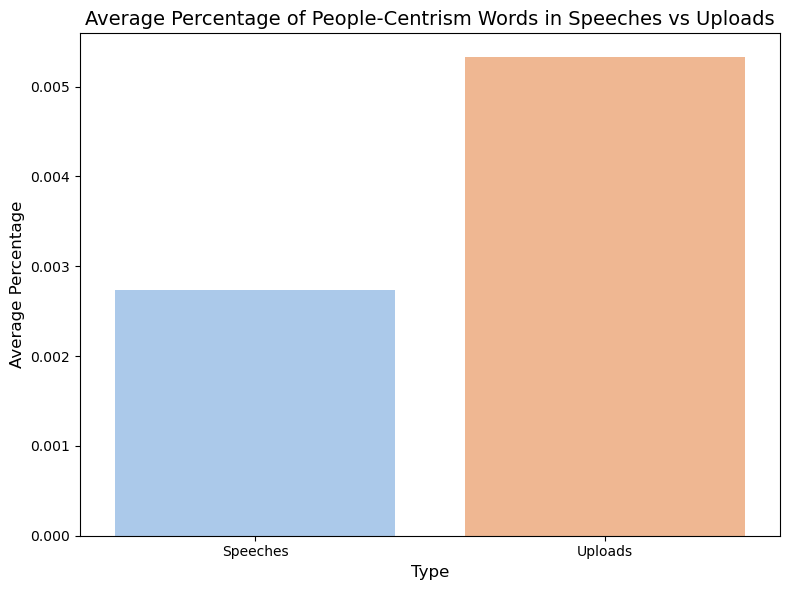

In [22]:
# Visualize the difference between the speeches and the uploads regaring the occourances of the words in the dictionary

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_dictionary_analysis(dataframe, dict_column_speeches, dict_column_uploads, title = 'Average Percentage of Dictionary Words in Speeches vs Uploads'):
    # Calculate the average percentage of dictionary words in speeches and uploads
    average_percentage_speeches = dataframe[dict_column_speeches].mean()
    average_percentage_uploads = dataframe[dict_column_uploads].mean()

    # Prepare data for visualization
    data = {
        'Type': ['Speeches', 'Uploads'],
        'Average Percentage': [average_percentage_speeches, average_percentage_uploads]
    }

    # Create a DataFrame for the plot
    df = pd.DataFrame(data)

    # Plot the bar chart
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df, x='Type', y='Average Percentage', palette='pastel')

    # Add labels and title
    plt.title(title, fontsize=14)
    plt.xlabel('Type', fontsize=12)
    plt.ylabel('Average Percentage', fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()
visualize_dictionary_analysis(
    dict_speeches_with_transcriptions, 
    'dict_percentage_docpeoplecentrism', 
    'dict_percentage_transcription_text_docpeoplecentrism',
    title = 'Average Percentage of People-Centrism Words in Speeches vs Uploads')

### 3.4 Emotions

The following analysis test the hypotheses

- <b> 3.1 </b> The uploaded speeches have a more negative sentiment on average.
- <b> 3.2 </b> The uploaded speeches contain more hate speech.

#### 3.4.1 Sentiment-Analysis

Watch out: This takes a long time

In [ ]:
import torch
from germansentiment import SentimentModel

# Load a suitable dataframe
if os.path.exists("data/speeches_with_transcriptions_df.pkl"):
    speeches_with_transcriptions_df = pd.read_pickle("data/speeches_with_transcriptions_df.pkl")
elif os.path.exists("data/speeches_with_transcriptions_df.csv"):
    speeches_with_transcriptions_df = pd.read_csv("data/speeches_with_transcriptions_df.csv")
else:
    print("No data found. Please run the alignement code block first.")

sentiment_df = speeches_with_transcriptions_df.copy()
del speeches_with_transcriptions_df

model = SentimentModel()

sentiment_df['sentence_list_speech'] = sentiment_df['doc'].apply(lambda x: [sent.text for sent in nlp(x).sents])
sentiment_df['sentence_list_upload'] = sentiment_df['transcription_text'].dropna().apply(lambda x: [sent.text for sent in nlp(x).sents])

sentiment_df['speech_sentiments'] = sentiment_df['sentence_list_speech'].dropna().apply(
    lambda x: [model.predict_sentiment(x)]
)
sentiment_df['upload_sentiments'] = sentiment_df['sentence_list_upload'].dropna().apply(
    lambda x: [model.predict_sentiment(x)]
)

sentiment_df.to_pickle("data/sentiment_df.pkl")


/var/folders/r8/9skhg1fj23156y4c7f_cvm880000gn/T/ipykernel_45151/3832152316.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


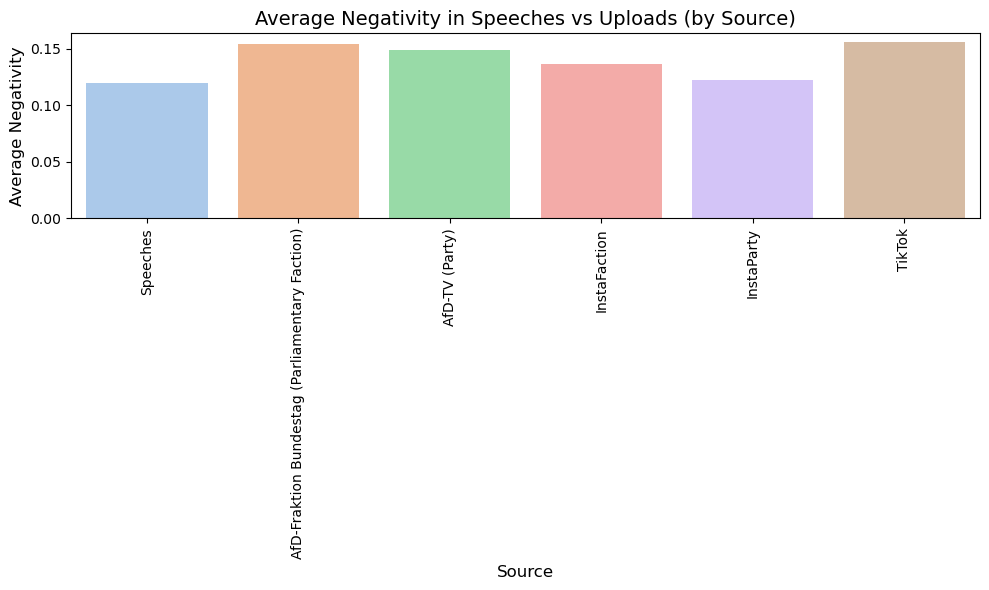

In [64]:
from collections import Counter
# Get the average sentiment of the speeches and uploads
#sentiment_df.reset_index(inplace=True)

sentiment_df['speech_sentiment_counted'] = sentiment_df['speech_sentiments'].dropna().apply(
    lambda x: Counter([item for sublist in x for item in sublist])
)
sentiment_df['upload_sentiment_counted'] = sentiment_df['upload_sentiments'].dropna().apply(
    lambda x: Counter([item for sublist in x for item in sublist])
)
# Get the average sentiment of the speeches and uploads
sentiment_df['speech_sentiment_negativity'] = sentiment_df['speech_sentiment_counted'].dropna().apply(
    lambda x: x['negative'] / (x['negative'] + x['neutral'] + x['positive']) if (x['negative'] + x['neutral'] + x['positive']) > 0 else 0
)
sentiment_df['upload_sentiment_negativity'] = sentiment_df['upload_sentiment_counted'].dropna().apply(
    lambda x: x['negative'] / (x['negative'] + x['neutral'] + x['positive']) if (x['negative'] + x['neutral'] + x['positive']) > 0 else 0
)
# Visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

# Split the 'uploaded_source' into multiple rows if there are multiple sources
local_sentiment_df = sentiment_df.copy()
local_sentiment_df['uploaded_source'] = local_sentiment_df['uploaded_source'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
local_sentiment_df = local_sentiment_df.explode('uploaded_source')

# Calculate average negativity for speeches
average_negativity_speeches = sentiment_df['speech_sentiment_negativity'].mean()

# Calculate average negativity for uploads, grouped by 'uploaded_source'
average_negativity_uploads = local_sentiment_df.groupby('uploaded_source')['upload_sentiment_negativity'].mean().reset_index()

# Add speeches as a separate category for comparison
average_negativity_uploads = pd.concat([
    pd.DataFrame({'uploaded_source': ['Speeches'], 'upload_sentiment_negativity': [average_negativity_speeches]}),
    average_negativity_uploads
])

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=average_negativity_uploads,
    x='uploaded_source',
    y='upload_sentiment_negativity',
    palette='pastel'
)

# Add labels and title
plt.title('Average Negativity in Speeches vs Uploads (by Source)', fontsize=14)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Average Negativity', fontsize=12)
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

#### 3.4.2 Hate-Speech

In this case two different classifiers were used, as the first one seems to detect very few cased of hate speech.

In [ ]:
import torch
from happytransformer import HappyTextClassification

# Load a suitable dataframe
if os.path.exists("data/speeches_with_transcriptions_df.pkl"):
    speeches_with_transcriptions_df = pd.read_pickle("data/speeches_with_transcriptions_df.pkl")
elif os.path.exists("data/speeches_with_transcriptions_df.csv"):
    speeches_with_transcriptions_df = pd.read_csv("data/speeches_with_transcriptions_df.csv")
else:
    print("No data found. Please run the alignement code block first.")

hatespeech_df = speeches_with_transcriptions_df.copy()
del speeches_with_transcriptions_df


mps_device = torch.device("mps")

model = HappyTextClassification('BERT', 'Hate-Speech-CNERG/dehatebert-mono-german', 2)
print("Model loaded")

hatespeech_df['sentence_list_speech'] = hatespeech_df['doc'].apply(lambda x: list(nlp(x).sents))
hatespeech_df['sentence_list_upload'] = hatespeech_df['transcription_text'].dropna().apply(lambda x: list(nlp(x).sents))
print("Sentence lists created")

hatespeech_df['speech_hate_speech'] = hatespeech_df['sentence_list_speech'].dropna().apply(
    lambda x: [model.classify_text(sents.text) for sents in x]
)
hatespeech_df['upload_hate_speech'] = hatespeech_df['sentence_list_upload'].dropna().apply(
    lambda x: [model.classify_text(sents.text) for sents in x]
)
hatespeech_df.to_csv("data/hatespeech_df.csv")

In [ ]:
model = HappyTextClassification('BERT', 'Andrazp/multilingual-hate-speech-robacofi', 2)

# Define a function to truncate text to the model's maximum token limit
def classify_text_with_truncation(text, max_length=512):
    tokens = model.tokenizer.tokenize(text)
    if len(tokens) > max_length:
        text = model.tokenizer.convert_tokens_to_string(tokens[:max_length])  # Truncate to the first `max_length` tokens
    return model.classify_text(text)

hatespeech_df['speech_hate_speech_2'] = hatespeech_df['sentence_list_speech'].dropna().apply(
    lambda x: [classify_text_with_truncation(sents.text) for sents in x]
)
hatespeech_df['upload_hate_speech_2'] = hatespeech_df['sentence_list_upload'].dropna().apply(
    lambda x: [classify_text_with_truncation(sents.text) for sents in x]
)
hatespeech_df.to_csv("data/hatespeech_df.csv")

In [46]:
hatespeech_df = pd.read_csv("data/hatespeech_df.csv")
# Make it a list of dictionaries
hatespeech_df['speech_hate_speech'] = hatespeech_df['speech_hate_speech'].dropna().apply(
    lambda x: x.split("Text") if isinstance(x, str) else x
)
hatespeech_df['upload_hate_speech'] = hatespeech_df['upload_hate_speech'].dropna().apply(
    lambda x: x.split("Text") if isinstance(x, str) else x
)
hatespeech_df['speech_hate_speech_2'] = hatespeech_df['speech_hate_speech_2'].dropna().apply(
    lambda x: x.split("Text") if isinstance(x, str) else x
)
hatespeech_df['upload_hate_speech_2'] = hatespeech_df['upload_hate_speech_2'].dropna().apply(
    lambda x: x.split("Text") if isinstance(x, str) else x
)


hatespeech_df['speech_hate_speech_proportion'] = hatespeech_df['speech_hate_speech'].dropna().apply(
    lambda x: sum([1 for item in x if "HATE" in item and not "NON" in item]) / sum([1 for item in x if "HATE" in item]) if isinstance(x, list) else 0
)
hatespeech_df['upload_hate_speech_proportion'] = hatespeech_df['upload_hate_speech'].dropna().apply(
    lambda x: sum([1 for item in x if "HATE" in item and not "NON" in item]) / sum([1 for item in x if "HATE" in item]) if isinstance(x, list) else 0
)
hatespeech_df['speech_hate_speech_proportion_2'] = hatespeech_df['speech_hate_speech_2'].dropna().apply(
    lambda x: sum([1 for item in x if "offensive" in item and not "not" in item]) / sum([1 for item in x if "offensive" in item]) if isinstance(x, list) else 0
)
hatespeech_df['upload_hate_speech_proportion_2'] = hatespeech_df['upload_hate_speech_2'].dropna().apply(
    lambda x: sum([1 for item in x if "offensive" in item and not "not" in item]) / sum([1 for item in x if "offensive" in item]) if isinstance(x, list) else 0
)

hatespeech_df.to_pickle("data/hatespeech_df.pkl")

In [55]:
hatespeech_df = pd.read_pickle("data/hatespeech_df.pkl")

# Average the results
average_hate_speech_speeches = hatespeech_df['speech_hate_speech_proportion'].mean()
print("Average of hate speech in speeches in first model", average_hate_speech_speeches)
average_hate_speech_uploads = hatespeech_df['upload_hate_speech_proportion'].mean()
print("Average of hate speech in uploads in first model", average_hate_speech_uploads)
average_hate_speech_speeches_2 = hatespeech_df['speech_hate_speech_proportion_2'].mean()
print("Average of hate speech in speeches in second model", average_hate_speech_speeches_2)
average_hate_speech_uploads_2 = hatespeech_df['upload_hate_speech_proportion_2'].mean()
print("Average of hate speech in uploads in second model", average_hate_speech_uploads_2)

Average of hate speech in speeches in first model 0.01066875032318448
Average of hate speech in uploads in first model 0.01805887288621341
Average of hate speech in speeches in second model 0.05797045340441477
Average of hate speech in uploads in second model 0.14045311453433


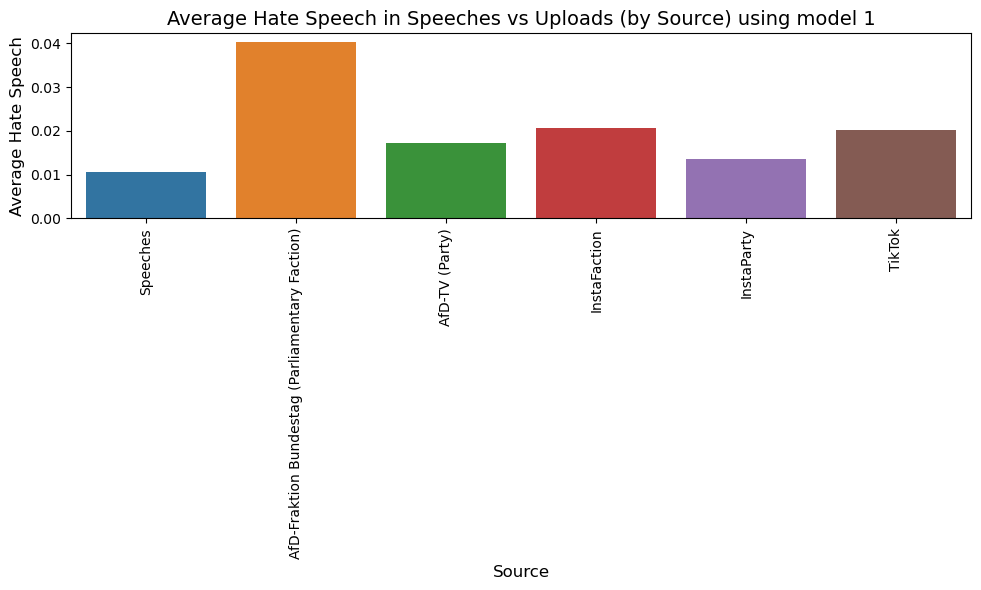

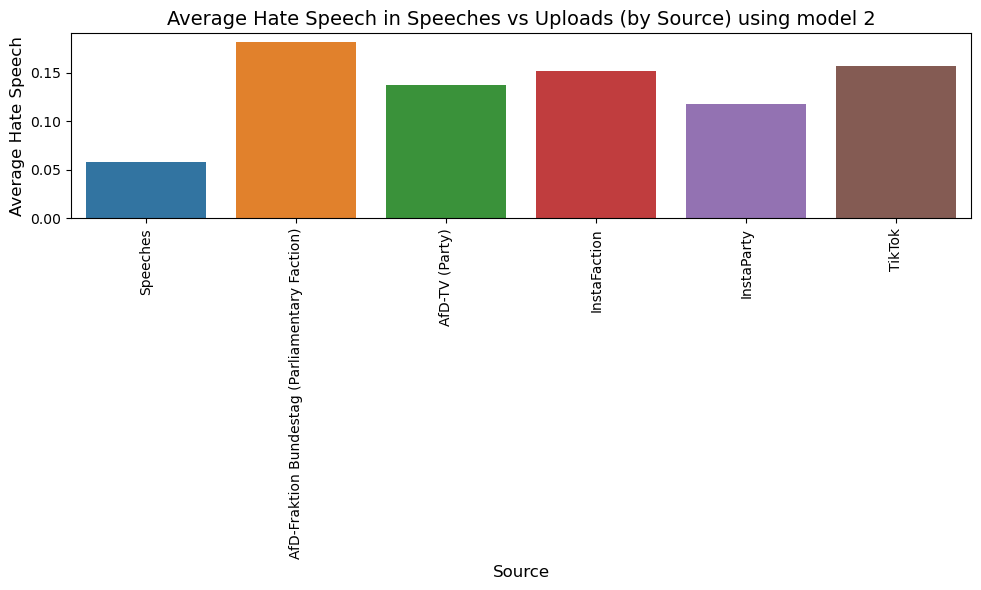

In [59]:
hatespeech_df = pd.read_pickle("data/hatespeech_df.pkl")

# Visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_hate_speech(model = '2'):
    column_name_uploads = 'upload_hate_speech_proportion_2' if model == '2' else 'upload_hate_speech_proportion'
    column_name_speeches = 'speech_hate_speech_proportion_2' if model == '2' else 'speech_hate_speech_proportion'

    # Create a local copy of the DataFrame to avoid modifying the global variable
    local_hatespeech_df = hatespeech_df.copy()

    # Split the 'uploaded_source' into multiple rows if there are multiple sources
    local_hatespeech_df['uploaded_source'] = local_hatespeech_df['uploaded_source'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
    local_hatespeech_df = local_hatespeech_df.explode('uploaded_source')

    # Calculate average hate speech for speeches
    average_hate_speech_speeches = hatespeech_df[column_name_speeches].mean()
    # Calculate average hate speech for uploads, grouped by 'uploaded_source'
    average_hate_speech_uploads = local_hatespeech_df.groupby('uploaded_source')[column_name_uploads].mean().reset_index()
    # Add speeches as a separate category for comparison
    average_hate_speech_uploads = pd.concat([
        pd.DataFrame({'uploaded_source': ['Speeches'], column_name_uploads: [average_hate_speech_speeches]}),
        average_hate_speech_uploads
    ])
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=average_hate_speech_uploads,
        x='uploaded_source',
        y=column_name_uploads,
        hue='uploaded_source'
    )
    # Add labels and title
    titel = 'Average Hate Speech in Speeches vs Uploads (by Source) using model 2' if model == '2' else 'Average Hate Speech in Speeches vs Uploads (by Source) using model 1'
    plt.title(titel, fontsize=14)
    plt.xlabel('Source', fontsize=12)
    plt.ylabel('Average Hate Speech', fontsize=12)
    plt.xticks(rotation=90)

    # Show the plot
    plt.tight_layout()
    plt.show()

visualize_hate_speech(model = '1')
visualize_hate_speech(model = '2')

### 3.5 Syntax

The following analysis test the hypotheses:

- <b> 4.1 </b> The uploaded speeches are less complex.
    - <b> 4.1.1 </b> They use simpler sentence structures.
    - <b> 4.1.2 </b> They use fewer borrowed words.
- <b> 4.2 </b> More active sentence structures are used in the uploaded speeches.
- <b> 4.3 </b> There are more imperatives and Calls to action in the uploaded speeches.
- <b> 4.4 </b> There are more rheorical questions in the uploaded speeches
- <b> 4.5 </b> The uploaded speeches contain more repetitions in the speech

In [ ]:
# @TODO